# MIT - Machine Learning with Inverse Graphics


## Setup

Below some setup we need for running everything on Colab. Feel free to skip this section.

This cell sets address to save library

In [ ]:
# set address to save library
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
os.symlink('/content/drive/My Drive/Colab Notebooks/inverse graphics/hw2/libraries', nb_path) # save libraries in src and make symlink at nb_path. Add nb_path to path and use library
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [ ]:
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Generator, Dict

My Verision

In [ ]:
%%script echo skipping
# # Visualization libraries
# import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# # To make code more readable: some helpful Python 3 type hints
# from typing import Callable, List, Optional, Tuple, Generator, Dict

!pip install --target=$nb_path --upgrade scikit-image
!pip install --target=$nb_path --upgrade einops
!pip install --target=$nb_path imageio-ffmpeg

skipping


Original version

In [ ]:
%%script echo skipping
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Generator, Dict

!pip install --upgrade scikit-image
!pip install --upgrade einops
!pip install imageio-ffmpeg

skipping


In [ ]:
# go to directory where pytorch3d library is located at
!pwd
%cd "/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library"

/content
/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library


In [ ]:
import pytorch3d

Set device

In [ ]:
import torch
print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

Installed Torch version: 1.13.0+cu116
cpu


### Testing your code



In [ ]:
def check_function(test_name, function_name, test_input, test_output):
    try:
        student_output = function_name(*test_input)
    except TypeError as error:
        print("Function", test_name, "has a error and didn't run cleanly. Error:", error)
        return False
    if isinstance(student_output, tuple):
        student_output = list(student_output)
    else:
        student_output = [student_output]

    for i in range(len(test_output)):
        if not torch.allclose(student_output[i], test_output[i], rtol=1e-03):
            print(test_name, ": Your function DOES NOT work.")
            return False
    print(test_name, ": Your function works!")
    return True

def check_losses(test_name, losses_array, loss_threshold):
    average_loss_last5 = np.mean(losses_array[-5:]) # losses -> losses_array
    if average_loss_last5 >= loss_threshold:
        print(test_name, ": Your function isn't optimized well")
        return False
    else:
        print(test_name, ": Your function works!")
    return True

# Part 1: MLPs, Neural Fields & First-order optimization

In this part of the assignment, you will implement some basic neural network layers in Pytorch, and fit a neural network to a 2D grayscale image - our first example of a "neural field"!

In [ ]:
from torch import nn
from torch.utils.data import DataLoader, IterableDataset

import numpy as np

# scikit-image lets us do basic image image-processing tasks.
import skimage
import skimage.transform

In [ ]:
def print_params(module):
    for name, param in module.named_parameters(): # compared to module.parameters(), named_parameters() also return 'name' of each paramter..
        print(f"{name}: {tuple(param.shape)}")



weight: (256, 2)
bias: (256,)


In [ ]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')

        if m.bias is not None:
            nn.init.constant_(m.bias, 0)



## 1.1. Neural Fields: Fitting an MLP to an image



In [ ]:
def get_norm_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel 
    coordinates, with (0,0) the top left corner at (1, 1) the bottom right corner.

    x is the first coordinate (xy_pix[..., 0]) and y is the second one (xy_pix[..., 1]).
    
    Note that the first axis of the array is the y-axis (or "height"), 
    as these are the rows, and the second axis is the x-axis.

    Returns:
        xy_pix: 
    """
    x = torch.linspace(0, 1, steps=x_resolution)
    # x = torch.linspace(0, 1, steps=x_resolution, device=device)
    y = torch.linspace(0, 1, steps=y_resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy') #xx, yy shape = y_resolution*x_resolution because I use 'xy'. x is col index, y is row index
    xy_pix = torch.stack((xx,yy), dim=-1).reshape(-1,2)

    return xy_pix


    # xs = torch.linspace(0, 1, x_resolution, device=device)
    # ys = torch.linspace(0, 1, y_resolution, device=device)
    # x, y = torch.meshgrid(xs, ys, indexing='xy')
    # xy_pix = torch.stack((x, y), dim=-1)
    # return xy_pix

Next, we will build a dataset that returns a tuple of ```(all_pixel_coords, all_pixel_values)```, where `all_pixel_coords` are the per-pixel normalized coordinates of every pixel and `all_pixel_values` are the corresponding grey-scale values.

We will operate on an image with resolution (128, 128):

In [ ]:
image_size = (128, 128)

First, let's get an image from scikit-learn:

/content/notebooks/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


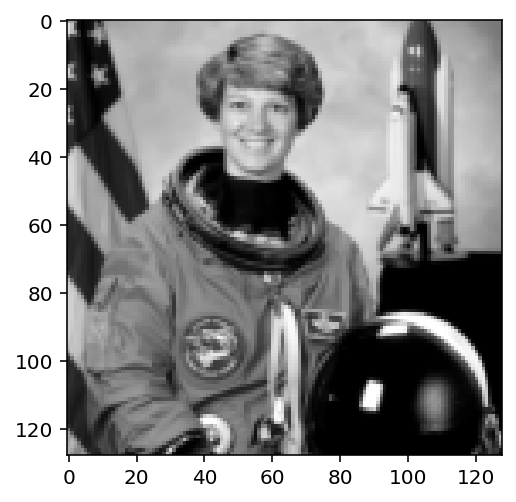

In [ ]:
# Load the "Astronaut" image from scikit-image, rescale it,
# and convert it to a grayscale torch.Tensor.
image = skimage.data.astronaut()
image = skimage.transform.resize(
    image, image_size, anti_aliasing=True
)
image = skimage.color.rgb2gray(image)

plt.imshow(image, cmap='gray') # added cmap='gray'
plt.show()

image = torch.tensor(image).to(device)  # save image to devcie so that later when we use image, we want to use it in device

In [ ]:
image.shape

torch.Size([128, 128])

To make this into a dataset for a neural field, below:
1. Generate normalized pixel coordinates for every pixel
2. Reshape the image to the shape (height*width, 1)
3. Reshape the pixel coordinates to the shape (height*width, 2)

In [ ]:
def get_training_data(image: torch.Tensor): # image.shape = (B, H, W)
    """ 
    In this function, you initialize a grid of normalized pixel grid and
    load the target image on device for training of a neural network fitting the
    image given the normalizd pixel grid as input. 
    Please ensure that the points are of shape (B, N, 2) where B is the batch 
    size (fixed as 1 for this example), and N is the number of points (W x H). 
    The image pixels would be on dimension (B, N, 1) as the image is grayscale. 
    Do not forget to set the both x and b on device.

    Returns:
        x: normalized pixel coordinate, generated using shape of image. (B=1, N, 2)
        b: image pixels (B=1, N, 1)

    """    
    batch_size = 1
    y_resolution, x_resolution = image.shape

    x = get_norm_pixel_coordinates(y_resolution, x_resolution).reshape(batch_size, -1, 2).to(device) # xy_norm_grid.shape = (batchsize, y_reso * x_reso, 2)
    b = image.reshape(batch_size, -1, 1).to(device) # image pixel values
  
    return x, b

check_function("get_training_data", 
               get_training_data,
               [image],
               [get_norm_pixel_coordinates(128, 128).reshape(1, -1, 2).to(device),
                image.reshape(1, -1, 1).to(device)])

get_training_data : Your function works!


True

To use this data in a training loop, we'll wrap it in a generator. Generators must first be instantiated by calling them (like a normal python function). Then, `next()` can be called on the generator handle, see below:  
*note: A generator is a special type of function which does not return a single value, instead, it returns an iterator object with a sequence of values. In a generator function, a yield statement is used rather than a return statement.  

In [ ]:
x, b = get_training_data(image)  # since we use image, x is normalized grid pixel positions and 
# b is ground truth (image's real pixel values) at pixel position accordingly

def astronaut():
    while True:
        yield x, b

dataset = astronaut()
coords, pixels = next(dataset)
print(coords.shape)
print(pixels.shape)

torch.Size([1, 16384, 2])
torch.Size([1, 16384, 1])


Now, let's define a neural network. Below, use the `nn.Sequential` operator to build an MLP object `mlp` with:
1.   A (linear, ReLU) layer with 2 input dimensions and 256 output dimensions
2.   Two (linear, ReLU) hidden layers with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 1 ouput dimension (**no** nonlinearity).

Don't forget to copy the MLP to the correct device with .to(device)

In [ ]:
# TODO: Define a mlp based on the specifications listed above.
mlp = nn.Sequential(nn.Linear(2, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 1)).to(device)

# TODO: Apply the weight initialization using the init_weights_normal function.
mlp.apply(init_weights_normal)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

We are now ready to write a function to sample our neural field at the pixel coordinates and plot the output. Below, implement the missing parts:

In [ ]:
def sample_plot_img_field(
    field: nn.Module,
    image_size: Tuple[int, int],
    ax = None
    ):

    coords = get_norm_pixel_coordinates(*image_size).reshape(1, -1, 2).to(device)

    with torch.no_grad():
    # with torch.enable_grad():
        # Sample "field" with these coordinates
        model_out = field(coords).to(device)
    #########

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # ax.imshow(model_out.cpu().view(*image_size).detach().numpy())
    
    ax.imshow(model_out.cpu().view(*image_size).detach().numpy(), cmap='gray') # maybe try this? since 
    # gt image is gray scale?
    return model_out

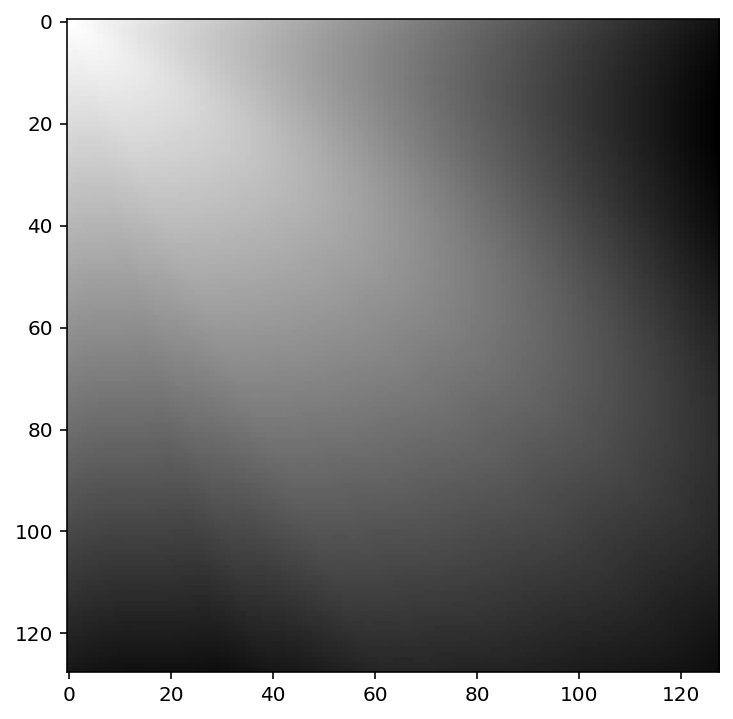

In [ ]:
_ = sample_plot_img_field(mlp, (128, 128)) # randomly (using kaimen_random_ initializer) evaluated pixel values at each pixel

Next, let's implement the loss we will use to compare the output of the MLP to ground-truth. 

Specifically, we will implement a simple mean-squared-error loss. 

In [ ]:
def mse_loss(mlp_out, gt):
    return ((mlp_out - gt)**2).mean()

We're now ready to formulate an iterative optimization loop to fit our MLP to the image. Below, complete the parts of the function marked as `TODO`.

In [ ]:
def fit_field(
    representation: nn.Module,
    data_iterator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None], # maybe referring to x, b from previous cells?
    loss_fn,
    resolution: Tuple,
    sample_plot_field_fn,
    steps_til_summary = 500,
    total_steps=2001,
    lr=1e-3
    ):
    # We will use the "Adam" stochastic gradient descent optimizer,
    # with a learning rate of 1e-3.
    optim = torch.optim.Adam(lr=lr, params=representation.parameters())

    losses = []
    for step in range(total_steps):

        model_input, ground_truth = next(data_iterator) # previous cell x, b where x = B,N,2: normalized pixel coordinates
        # ground_truth = b where b is real pixel values of image
        model_input = model_input.to(device)

        with torch.enable_grad():
          model_output = representation(model_input).to(device)
  
        loss = loss_fn(model_output, ground_truth).to(device)

        optim.zero_grad()
        loss.backward()
        optim.step()

        # Accumulate the losses so that we can plot them later
        losses.append(loss.detach().cpu().numpy())            

        # Every so often, we want to show what our model has learned.
        # It would be boring otherwise!
        if not step % steps_til_summary:
            print(f"Step {step}: loss = {float(loss.detach().cpu()):.4f}")
            sample_plot_field_fn(representation, resolution)
            plt.show()

    return losses

In [ ]:
%%script echo skipping
losses = fit_field(mlp, astronaut(), mse_loss,
                   image_size, sample_plot_img_field)


fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
axes[0, 0].plot(np.array(losses))
plt.show()


check_losses("Fitting MLP", losses, 0.03)

skipping


The "MLP" object is now a continuous representation of the image. That means you can sample it at any resolution! Below, we sample it at a resolution of (256, 256):

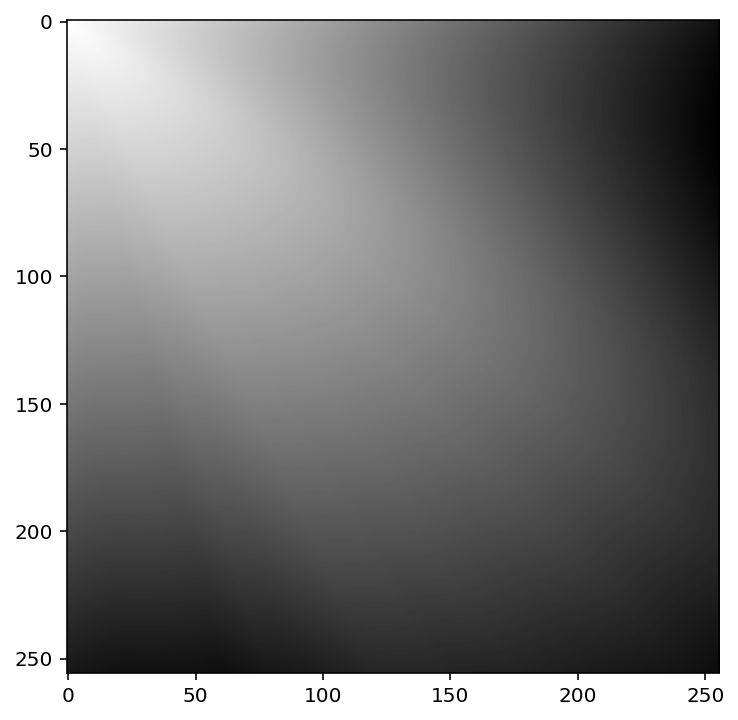

In [ ]:
_ = sample_plot_img_field(mlp, (256, 256))

But, **why does it look so bad**? Recall that in this regime of "overfitting" to a single image, the neural network basically serves as a kernel machine. It turns out that the kernel learned by the ReLU neural network couples together 2D points that don't belong together. 

## 1.2. Neural Fields with peaky kernels: SIREN

To alleviate the blurry reconstruction, we will build a neural network with a kernel function that only couples close-by points.

Specifically, we will use a SIREN network, a neural network with periodic activation functions.

There's lots of cool work on this - please find below some more resources if you find this direction intriguing.





In [ ]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

Using the pre-defined `SineLayer`, below, use the `nn.Sequential` operator to build a SIREN instance `siren` with:
1.   A SineLayer with 2 input dimensions and 256 output dimensions. **You will have to pass it the "is_first=True" as additional input.**
2.   Two hidden SineLayer with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 1 ouput dimension (**no** nonlinearity).

Don't forget to copy the siren to the correct device with .to(device)

In [ ]:
# TODO: Define siren as MLP with SineLayers with the specifications defined above
siren = nn.Sequential(SineLayer(2, 256, is_first=True),
                      nn.ReLU(inplace=True),
                      SineLayer(256, 256),
                      nn.ReLU(inplace=True),
                      SineLayer(256, 256),
                      nn.ReLU(inplace=True),
                      nn.Linear(256,1)).to(device)
print_params(siren)

0.linear.weight: (256, 2)
0.linear.bias: (256,)
2.linear.weight: (256, 256)
2.linear.bias: (256,)
4.linear.weight: (256, 256)
4.linear.bias: (256,)
6.weight: (1, 256)
6.bias: (1,)


Below, call the fit_field function to train the SIREN.

Step 0: loss = 0.2057


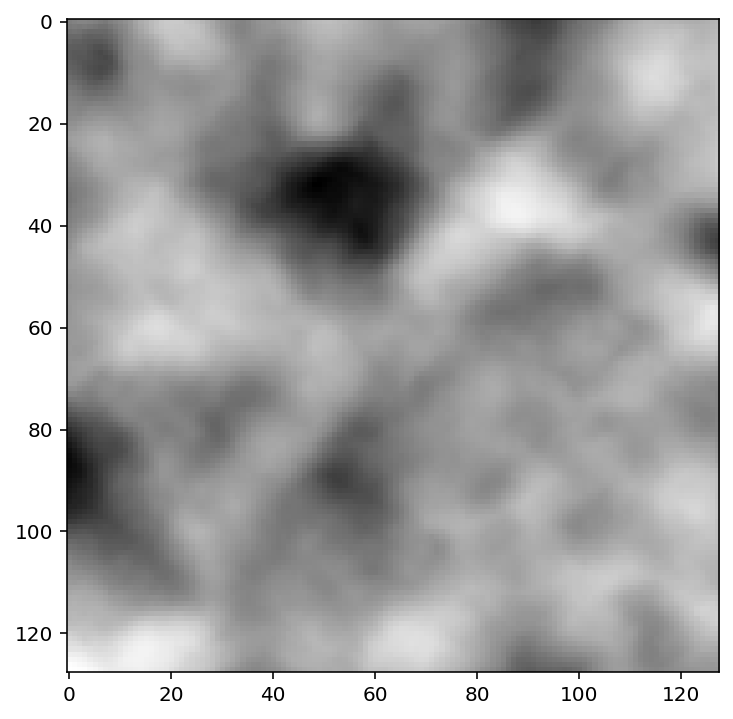

Step 500: loss = 0.0007


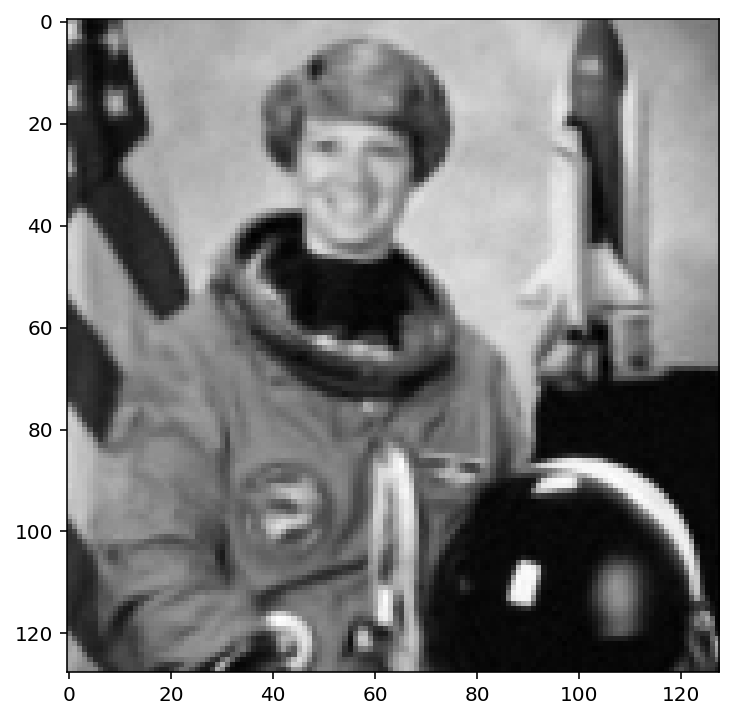

Step 1000: loss = 0.0005


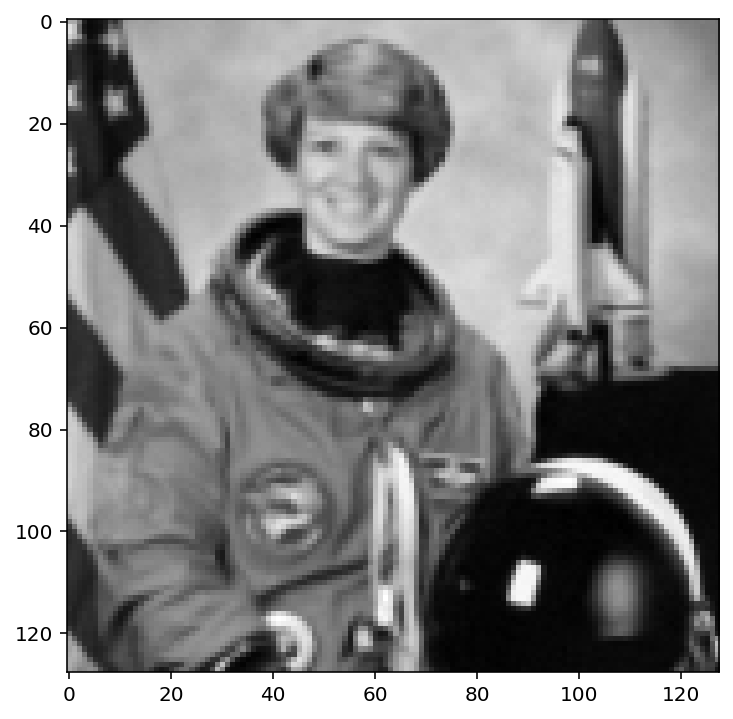

Step 1500: loss = 0.0012


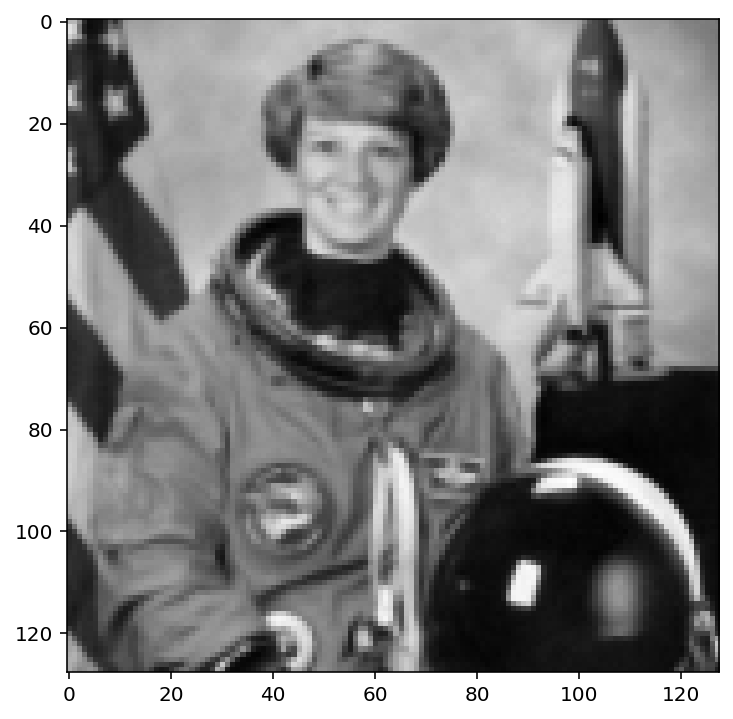

Step 2000: loss = 0.0000


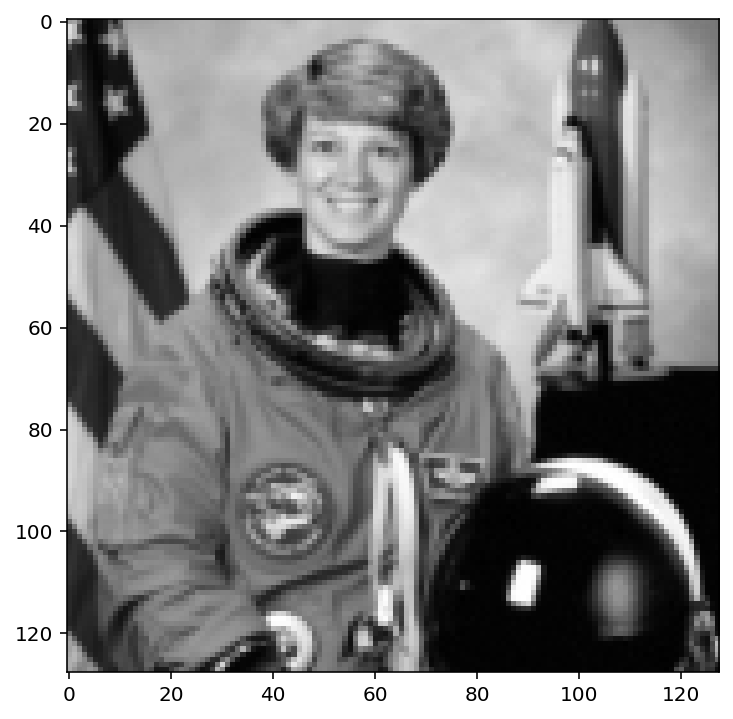

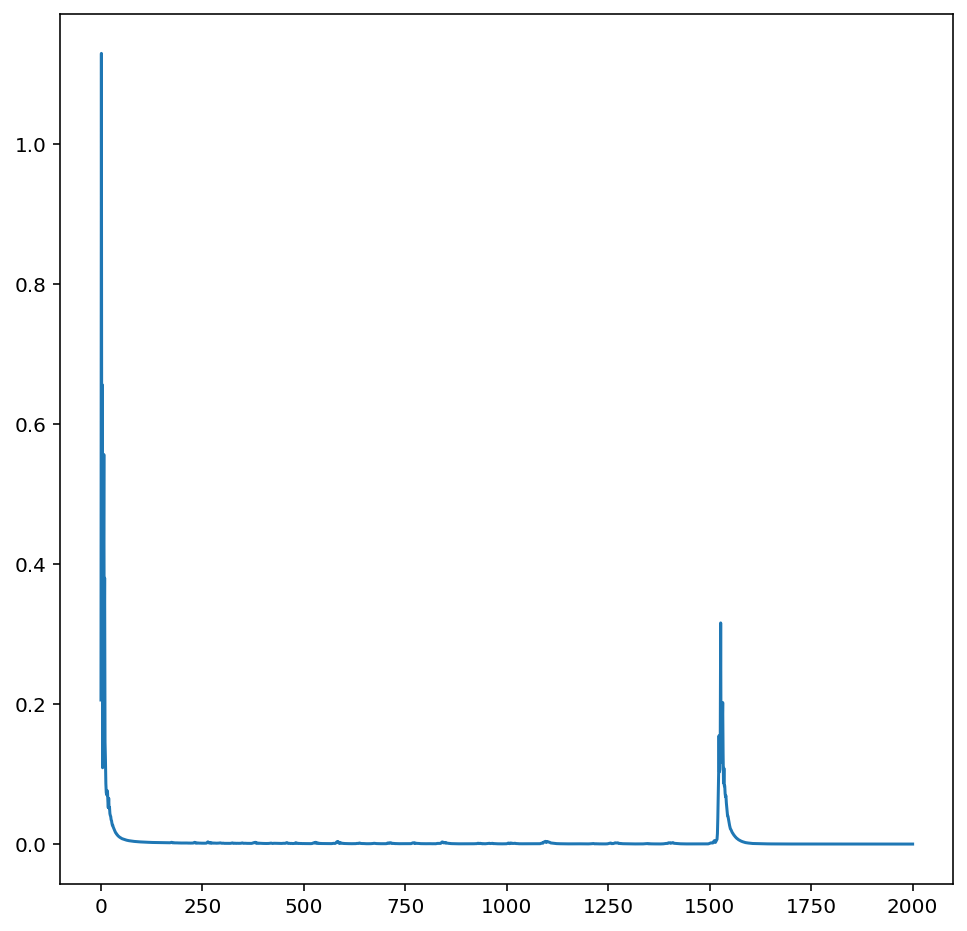

Fitting Siren : Your function works!


True

In [ ]:
losses = fit_field(siren, astronaut(), mse_loss,
                   image_size, sample_plot_img_field)

fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
axes[0, 0].plot(np.array(losses))
plt.show()

check_losses("Fitting Siren", losses, 1e-4)

Within only a few hundred iterations, we have now been able to regress the image values! 

However, again, note that there isn't anything particularly "interesting" happening here, from a machine learning perspective. All we have done is to engineer a different kernel function, or, in other words, picking a method by which we choose to interpolate the image pixels. 

## 1.3. Fitting an image to an image

We will illustrate this fact by a somewhat weird experiment: We will fit a *voxelgrid*, i.e., a 2D grid of pixel values, to the image. 

Specifically, we will build a pytorch module that has as its sole parameter a Tensor of shape `(1, 1, height, width)`. The forward pass of that pytorch module takes as input coordinates of shape (batch_size, num_points, 2) (i.e., 2d coordinates) and returns the value of the grid at that coordinate, interpolated via nearest neighbor or bilinear interpolation.

To this, end first read the documentation of grid_sample [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html). 

Below, implement the forward pass of the `PixelGrid` class. 

In [ ]:
import torch.nn.functional as F

class PixelGrid(nn.Module):
    # resolution_per_dim might mean that images have two dim, width, height.
    # so resolution of width and of height.    
    def __init__(self, resolution_per_dim, out_dim, mode='bilinear'):  #out_dim = C?
        super().__init__()
        self.grid = nn.Parameter(torch.rand(size=(1 , out_dim , *resolution_per_dim)))
        self.mode = mode
    
    def forward(self, coordinate):
        '''
        coordinate: (batch_size, num_points, 2). These are normal pixel coordinates.
        '''
        batch_size = coordinate.shape[0]
        num_points = coordinate.shape[1]
        coord = coordinate[None].permute(1,2,0,3)  # coordinate[None].shape = (1, batch_size, num_points, 2). here 2 is norm  coordinates 0~1

        values = F.grid_sample(self.grid, coord, self.mode)

        # Reshape & permute values to shape (batch_size, num_points, 1)
        values = values.reshape(batch_size, num_points, 1)

        return values

We can now instantiate our PixelGrid as follows. Note that the only parameter of the module is the grid itself.

In [ ]:
grid = PixelGrid((128, 128), 1, mode='nearest').to(device)
print_params(grid)

grid: (1, 1, 128, 128)


Now, `grid` is a differentiable function that maps a 2D coordinate to a float value. Thus, we can "fit" it to the image, just as we did with our neural fields before.

Below, call `fit_field` to fit the grid to the image.

Step 0: loss = 0.1641


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


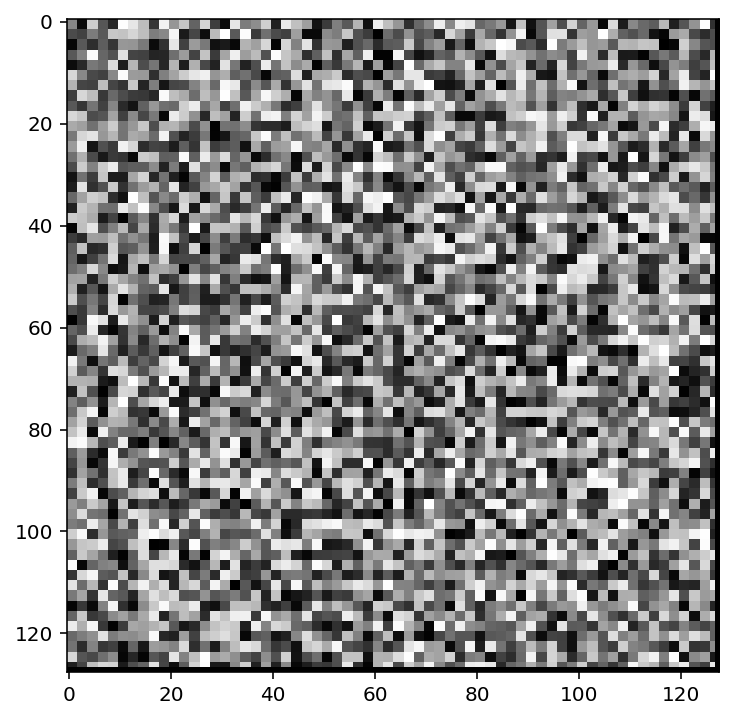

Step 500: loss = 0.0260


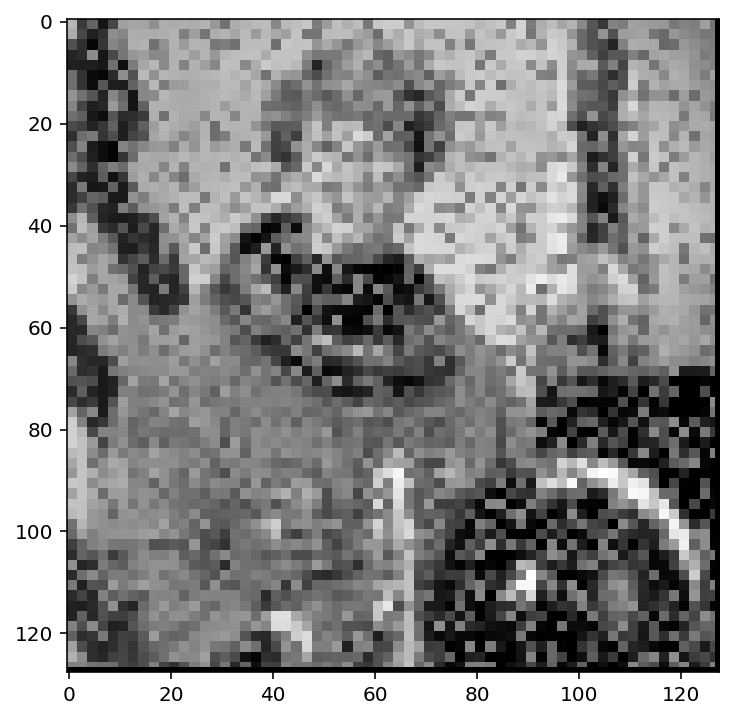

Step 1000: loss = 0.0082


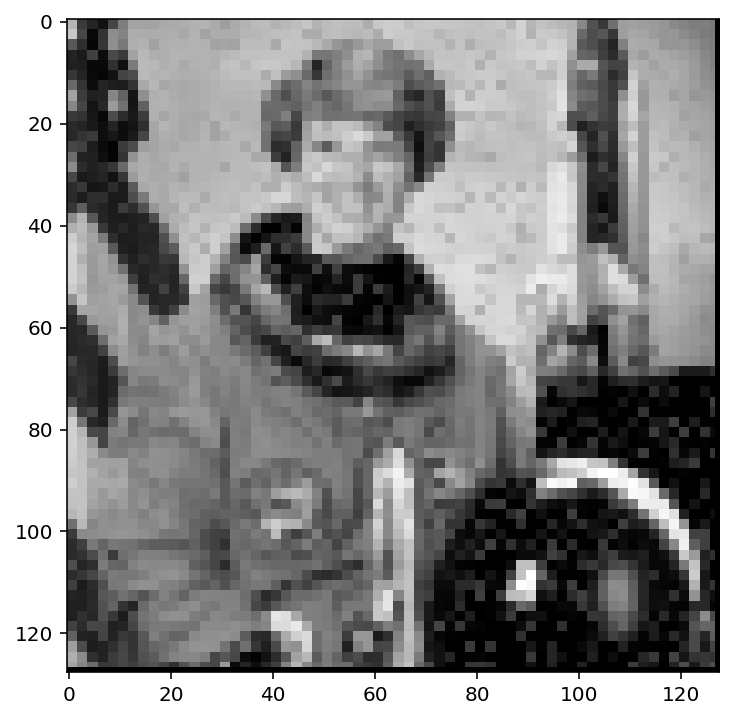

Step 1500: loss = 0.0063


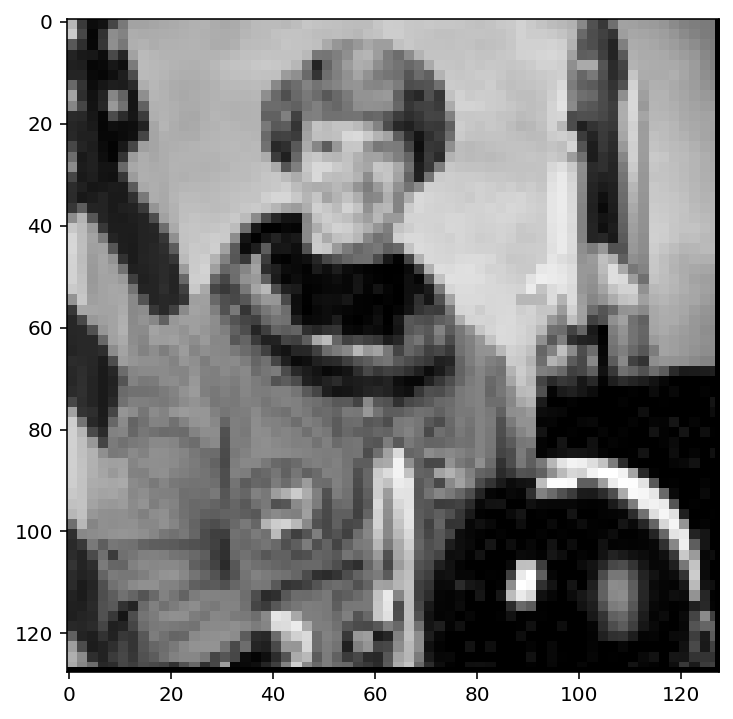

Step 2000: loss = 0.0062


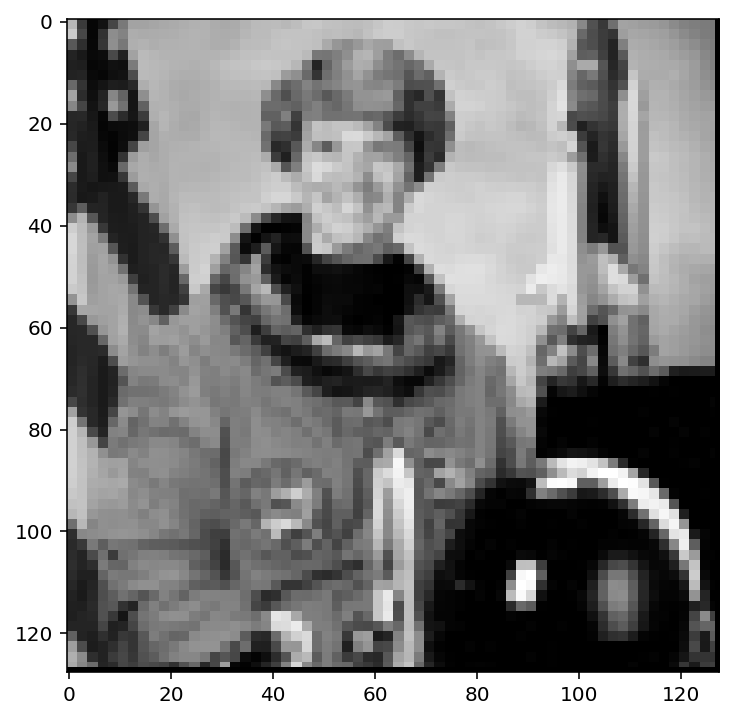

Fitting voxelgrid : Your function works!


True

In [ ]:
losses = fit_field(grid, astronaut(), mse_loss, image_size, sample_plot_img_field)
check_losses("Fitting voxelgrid", losses, 2e-2)

As we can see, we have perfectly "regressed" the image, surprising no-one ;)

But, why are neural fields interesting _at all_? The key reason is, basically, differentiable compression: An MLP can, during optimization, allocate capacity to high-frequency areas in the signal - kind of like an "adaptive resolution" data structure, like a quadtree / octree, but fully differentiable. Further, they also perform reasonable interpolation by themselves, without the need to hand-craft interpolation kernels.

In general, however, it is indeed the case that there is no "magic" here - there's nothing "intelligent" here, the neural field is really best compared to a voxelgrid with some pros and some cons.

These things will become more apparent in the next section.

In [ ]:
del siren
del grid
del mlp
del losses

# Part 2: Representing 3D Geometry: Neural Fields, Voxel Grids, Hybrid Discrete-Continuous Representations

We will now move on from 2D signals, such as images, to 3D signals, namely shapes. 



In [ ]:
def get_norm_voxel_coordinates(
    resolution_per_axis: Tuple[int, int, int],
    device: torch.device = torch.device('cpu')
    ):
    xyz_res = resolution_per_axis
    i, j, k = torch.meshgrid(torch.linspace(-1, 1, steps=xyz_res[0], device=device), 
                             torch.linspace(-1, 1, steps=xyz_res[1], device=device),
                             torch.linspace(-1, 1, steps=xyz_res[2], device=device))
    # i, j, k = torch.meshgrid(torch.linspace(-0.5, 0.5, steps=xyz_res[0], device=device), 
    #                          torch.linspace(-0.5, 0.5, steps=xyz_res[1], device=device),
    #                          torch.linspace(-0.5, 0.5, steps=xyz_res[2], device=device))

    xyz_vox = torch.stack([i.float(), j.float(), k.float()], dim=-1)
    return xyz_vox # xyz_vox.shape is maybe [i_res, j_res, j_res, 3]

Now, we'll need some ground-truth occupancy function to fit our 3D fields to. We'll keep it simple for now: Below, we have implemented the (analytical) occupancy function of a simple 3D sphere for you. 

In [ ]:
def sphere_occupancy(
    x: torch.Tensor # shape is maybe size=(1, num_points, 3)
):
    '''Occupancy function of a 3D sphere with radius 0.5.
    Returns (1, 0) if x is occupied and (0, 1) otherwise.
    '''
    occ = (x.norm(dim=-1, keepdim=True) < 0.5).float() # 0.5 here is radius, not likelihood 
    return torch.cat((occ, 1-occ), dim=-1) # size=(1, num_points, 2)

In [ ]:
vox_res = 32, 32, 32

Following the image case, we now implement a function that allows us to visualize the current state of our occupancy field. Below, complete the function `sample_plot_occ_field`:
1. Generate a grid of 3D coordinates using get_norm_voxel_coordinates
2. Sample the occupancy field passed into the function.

Original Version

In [ ]:
def sample_plot_occ_field(
    field,
    voxel_resolution: Tuple[int, int, int],
    ax = None
    ):

    coords = get_norm_voxel_coordinates(voxel_resolution).reshape(1, -1, 3).to(device)

    # Infer the field on the coords
    with torch.no_grad():
        out = field(coords) # out size=(1, num_points, 2)

    out = out.reshape(*voxel_resolution, 2).to(device) 
   
    # Slice voxelgrid and imshow slices
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    half_res = voxel_resolution[0] // 2

    axes[0].imshow(out[:, :, half_res, 0].squeeze().cpu())
    axes[1].imshow(out[half_res, :, :, 0].squeeze().cpu())
    axes[2].imshow(out[:, half_res, :, 0].squeeze().cpu())
    
    plt.show()

    del out
    del coords


Testing version

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def sample_plot_occ_field(
    field,
    voxel_resolution: Tuple[int, int, int],
    ax = None
    ): 
    # Get normalized pixel coordinates for image_size and reshape it to (1, N, 3)
    # where N is V_x, V_y, V_z are the dimensions defined in voxel_resolution.
    coords = get_norm_voxel_coordinates(voxel_resolution).reshape(1, -1, 3).to(device)
 
    # Infer the field on the coords
    with torch.no_grad():
        out = field(coords) # out size=(1, num_points, 2)  # this field is trained one at each step 0, 500, ..

    # Reshape the output as (V_x, V_y, V_z, 2) for V_x, V_y, V_z are the 
    # dimensions of the voxel grid.
    out = out.reshape(*voxel_resolution, 2).to(device) 

    # Slice voxelgrid and imshow slices
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    half_res = voxel_resolution[0] // 2

    im1 = axes[0].imshow(out[:, :, half_res, 0].squeeze().cpu()) # , cmap='gray'
    axes[1].imshow(out[half_res, :, :, 0].squeeze().cpu())
    axes[2].imshow(out[:, half_res, :, 0].squeeze().cpu())
    

  #  im1 = ax1.imshow(m1, interpolation='None')

    # divider = make_axes_locatable(axes[0])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im1, cax=cax, orientation='vertical')

    plt.show()

    del out
    del coords


Let's try it out on our ground-truth occupancy field:

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


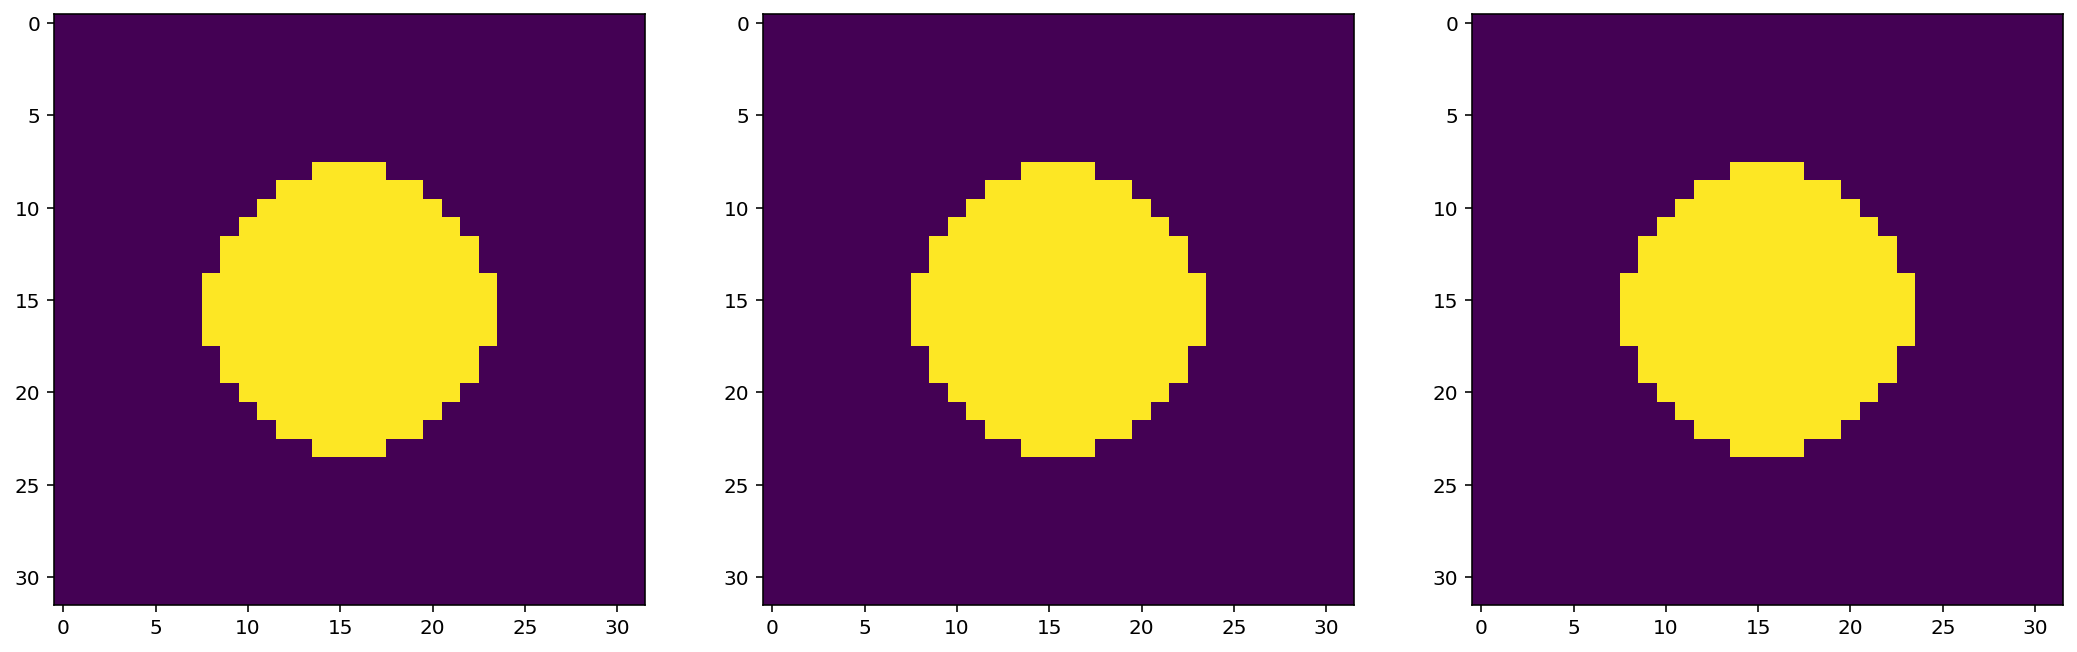

In [ ]:
sample_plot_occ_field(sphere_occupancy, (32, 32, 32))

Great! It remains to implement a little dataset that will allow us to fit this occupancy function in a training loop. We did that for you:

In [ ]:
def sphere_generator(voxel_resolution: Tuple[int, int, int]):     
    while True:        
        # coords = torch.rand(size=(1, num_points, 3)) # 0~1   
        # coords = (coords - 0.5) * 2 # -0.5 ~ 0.5  -> -1 ~ 1

        coords_for_gt = get_norm_voxel_coordinates(voxel_resolution).reshape(1, -1, 3).to(device)

        yield coords_for_gt, sphere_occupancy(coords_for_gt) # coords.shape = [1, num_points, 3], sphere_occupancy(coords).shape = [1, num_points, 2]

In [ ]:
def sphere_generator_random(voxel_resolution: Tuple[int, int, int]):     
    num_points = voxel_resolution[0]*voxel_resolution[1]*voxel_resolution[2]
    while True:
        num_points = voxel_resolution[0]* voxel_resolution[1] * voxel_resolution[2]
        coords = torch.rand(size=(1, num_points, 3)).reshape(1,-1,3) # 0~1   
        coords = (coords - 0.5) * 2 # -0.5 ~ 0.5  -> -1 ~ 1 .  coords are coordinates in [-1,1]**3 cubic
        # coords = get_norm_voxel_coordinates(voxel_resolution).reshape(1, -1, 3).to(device)        

        yield coords, sphere_occupancy(coords) # coords.shape = [1, num_points, 3], sphere_occupancy(coords).shape = [1, num_points, 2]

As a sanity check, let's sample a few batches from the dataset, and plot only those coordinates where our sphere_generator returns 1 (occupied). 



In [ ]:
def plot_pointcloud(
    vertices, 
    alpha=.5, 
    title=None, 
    max_points=10_000, 
    xlim=(-1, 1), 
    ylim=(-1, 1),
    zlim=(-1, 1)
    ):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """
    vertices = vertices.cpu()

    assert len(vertices.shape) == 2
    N, dim = vertices.shape
    assert dim==2 or dim==3

    if N > max_points:
        vertices = np.random.default_rng().choice(vertices, max_points, replace=False)
    fig = plt.figure(figsize=(6,6))
    if dim == 2:
        ax = fig.add_subplot(111)
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlabel("z")
        ax.set_zlim(zlim)
        ax.view_init(elev=120., azim=270) # azim starts at x axis. azim > 0 = rotate to y pos dir. top of camera is heading z pos axis

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(*vertices.T, alpha=alpha, marker=',', lw=.5, s=1, color='black')
    plt.show(fig)

Now, we'll randomly sample a bunch of batches from the generator and concatenate them into a single tensor, then plot the resulting pointcloud to see if it's correct.

torch.Size([1, 32768, 2])
torch.Size([1, 32768])
torch.Size([2165, 3])


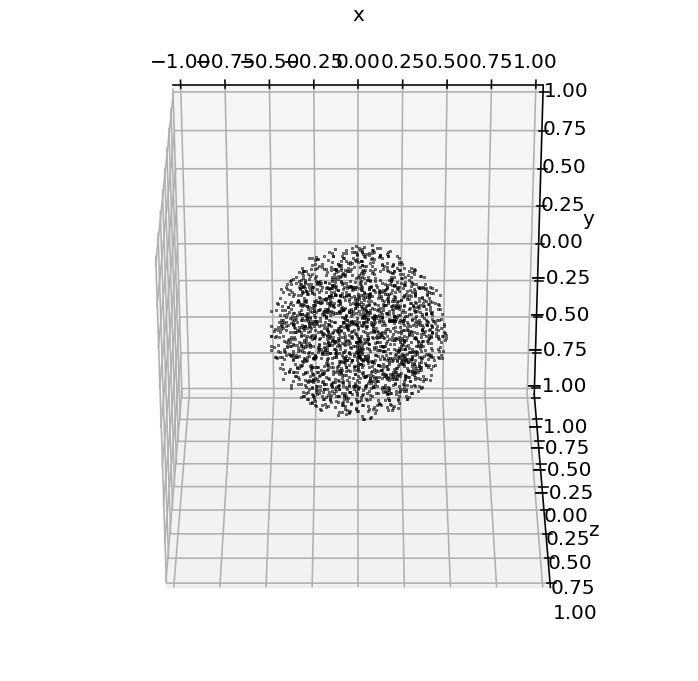

In [ ]:
# dataset = sphere_generator((32,32,32))
dataset = sphere_generator_random((32,32,32))
c, o = next(dataset) # c = coords, o = true/false values, # c.shape = [1, num_points, 3], o.shape = [1, num_points, 2] 
print(o.shape)
c = c[o[..., 0]!=0] 
print((o[..., 0]!=0).shape)
print(c.shape)
plot_pointcloud(c.cpu())

Neat. Let's try to fit it with a variety of neural and non-neural representations.

The occupancy function of a sphere is not particularly interesting. Next, we'll genreate the occupancy function of a ShapeNet object that we have stored as a voxelgrid:

## 2.1 Occupancy Networks with ReLU

We'll first use a ReLU neural network to fit this occupancy function. 

Now, let's define a neural network. Below, use the nn.Sequential operator to build an MLP object mlp_3d with:

1.   A (linear, ReLU) layer with 3 input dimensions and 256 output dimensions
2.   Two (linear, ReLU) hidden layer with 256 input and 256 output dimensions
3.   An output linear layer with 256 input and 2 ouput dimension.

In [ ]:
mlp_3d = nn.Sequential(nn.Linear(3, 256),
                       nn.ReLU(inplace=True),
                       nn.Linear(256,256),
                       nn.ReLU(inplace=True),
                       nn.Linear(256,256),
                       nn.ReLU(inplace=True),
                       nn.Linear(256,2)).to(device)

mlp_3d.apply(init_weights_normal)

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=2, bias=True)
)

Next, we will implement the loss. We will pick the loss as proposed in the paper "Occupancy Networks", namely, a binary cross-entropy loss.

In [ ]:
import torch.nn.functional as F
def occ_loss(mlp_out, gt):
  return F.binary_cross_entropy_with_logits(mlp_out, gt)

We will now fit this MLP to the occupancy function.




In [ ]:
%%script echo skipping
# TODO: Call the fit field function on mlp_3d on dataset with occ_loss.
#       Train for 2_001 steps with learning rate of 1e-4.

losses = fit_field(mlp_3d, dataset, occ_loss, vox_res, sample_plot_occ_field, lr=1e-4)

# plot losses 
fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
axes[0, 0].plot(np.array(losses))
plt.show()

check_losses("Fitting 3D MLP:", losses, 1e-2)


skipping


In [ ]:
del mlp_3d
del losses

## 2.2. Hybrid discrete-continuous 3D representation: voxel-neural-field

We will strike a different memory-to-compute trade-off by exploring hybrid discrete/continuous representations. We will begin with a voxelgrid - neural field - hybrid.

The key idea here is to use a discrete data structure, such as a voxelgrid, as a localized storage of feature vectors.

When we then want to sample a 3D coordinate, we first query into the discrete scene representation - in this case, a voxelgrid - obtaining a feature vector.

This feature vector is then decoded via a _small_ fully-connected neural network. 

It is critical that we use trilinear or higher-order interpolation when querying the voxelgrid - otherwise, information is lost, and the MLP cannot increase the effective resolution.



In [ ]:
class HybridVoxelNeuralField(nn.Module):
    def __init__(self, resolution_per_dim, feature_dim, out_dim, mode='bilinear'):
        super().__init__()
        self.mode = mode      
        # for each feature, i have a 3d box 
        self.grid = nn.Parameter(torch.rand(size=(1, feature_dim, *resolution_per_dim))).to(device) # think of this as an input      
 
        self.mlp = nn.Sequential(nn.Linear(feature_dim, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, out_dim)                                 
                                 ).to(device)        
 
        self.mlp.apply(init_weights_normal)

    
    def forward(self, coordinate): # coordinate.size = : [1, num_points, 3]. 
        sample features from the self.grid for the         
        coord = coordinate[None,None].clone().to(device) # coordinate[None,None].shape = (1, 1, batch_size, num_points, 3)
        # coord = coordinate.reshape(1, 32,32,32,3)

        # coordinate[n, d, h, w] specifices grid pixel locations x,y,and z. So eventually, we need a list of 3d coords,
        # i.e., [1, num_points, 3].. coordinate itself
        values = F.grid_sample(self.grid, coord, self.mode) # values.shape (N, feature_dim, D, H, W)?      
    
        # Permute the features from the grid_sample such that the feature 
        # dimension is the innermost dimension.
        feature_dim = values.shape[1] 
        # values = values.reshape(1, -1, feature_dim)

        # batch_size = coordinate.shape[0]
        # feature_dim = coordinate.shape[1]
        values = values.permute(0,2,3,4,1).reshape(1, -1, feature_dim) 

        # Evaluate the mlp on the input features.
        values = self.mlp(values)  #(values: 32768x8 and 2x256)   self.mlp(values) outputs each position's occ, 1-occ
        #########
        
        return values

In [ ]:
hybrid = HybridVoxelNeuralField((16, 16, 16), feature_dim=8, out_dim=2).to(device) # 16,16,16 is grid's resolution

In [ ]:
%%script echo skipping
dataset = sphere_generator_random((32,32,32))
losses = fit_field(
    hybrid, 
    dataset, # ([1, num_points, 3], [1, num_points, 2])..  3 is coordinates.. 2 is for [occ, 1-occ]
    occ_loss,
    (64, 64, 64), 
    sample_plot_occ_field, 
    total_steps=5_001, 
    lr=1e-4
)

check_losses("Fitting voxel neural field", losses, 5e-2)

skipping


Note how much faster this was! However, now we have to store a voxelgrid, which is awfully dense, especially when in many 3D scenes, there really is mostly empty space.

In [ ]:
del hybrid
del losses

## 2.3. Hybrid discrete-continuous 3D representation: groundplan-neural-field

Let's consider an alternative: we'll choose a different factorization of 3D using our hybrid data structure, namely a 2D grid of feature in the x-y plane, and a neural field in the y-axis - in other words, a neural "ground plan"!

Specifically, we now factorize our field into two components:
1. A 2D grid of features, $\Theta$, that lies in the XY-plane of our coordinate frame. Given a 3D world coordinate, we sample from $\Theta$ by dropping the y-coordinate (yielding a 2D coordinate) and sampling our ground plan at that 2D coordinate.
2. A little MLP that takes as input the y-coordinate (the one that we dropped), as well as the interpolated feature from the ground plan.


In [ ]:
class HybridGroundPlanNeuralField(nn.Module):
    def __init__(self, resolution_per_dim, feature_dim, out_dim, mode='bilinear'):
        super().__init__()        
      
        self.grid = torch.rand(size=(1, feature_dim, *resolution_per_dim)) # res.shape = (64, 64)

        self.mode = mode        
    
        self.mlp = nn.Sequential(nn.Linear(feature_dim+1, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, feature_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(feature_dim, out_dim)).to(device)        
      
        self.mlp.apply(init_weights_normal)
    
    def forward(self, coordinate):
        # Coordinates (batch_size, num_points, 3)..  which is model_input of next(data_iterator)
        # we will use xy as our grid in grid_sample which means xy has coordinates we want to sample at. coodinate is output of get_norm_voxel_coordinates,
        # which means all coords are in [-1,1], which makes sense.

        # Project coordinate onto xy-plane
        xy = coordinate[..., :2]  # xy.shape = (batch_size, num_points, 2)
        # xy = coordinate[..., 1:]

        # Add dim to get (batch_size, num_points, 1, 3).. I think we use this as "grid" in grid_sample function.. and should be 2 instead of 3?
        xy = xy[None].permute(1,2,0,3)

        # Extract the z-coordinate
        z = coordinate[..., 2] # size = [1, numpoints] maybe..?
        # z = coordinate[..., 0]

        # sample ground plan using the grid_sample function using the specified
        # mode and query xy coordinates.
        values = F.grid_sample(self.grid, xy, mode=self.mode) # xy is actually grid..  sample feature vector from self.grid at given xy coord
        # print(f'values shape: {values.shape}') = (batch_size, feature_dim, num_points)
        
        # reshape and permute such that values have a shape of 
        # (batch_size, num_points, latent_dimension)
        values = values.squeeze(-1).permute(0,2,1)  # value shape before permute = (batch_size, feature_dim, num_points)
        # [1, 64, 32768] -> [1, 32768, 64]

        # Concatenate with z coordinate and infer the mlp on values and store 
        # it in variable values.
        # values.shape = [1, 32768, 65]
        values = torch.cat((values, z.unsqueeze(-1)), dim=-1) # concatenate to feature_dim because mlp's input dim is feature_dim + 1
        # print(f'values shape after cat: {values.shape}')
        values = self.mlp(values)
        return values #[1, 32768, 2]
        
        ######



In [ ]:
hybrid_ground_plan = HybridGroundPlanNeuralField((64, 64), feature_dim=64, out_dim=2).to(device)

In [ ]:
%%script echo skipping
dataset = sphere_generator_random((32,32,32)) # my line
losses = fit_field(
    hybrid_ground_plan, 
    dataset, 
    occ_loss,
    (64, 64, 64), # resolution we want as output
    sample_plot_occ_field, 
    total_steps=5_001, 
    lr=1e-3
)

check_losses("Fitting groundplan", losses, 1e-2)

skipping


# Part 3: Differentiable Rendering

Now, let's move on to differentiable rendering and inverse graphics - i.e., fitting of a 3D representation given only images. 


## 3.0. Multi-view geometry functions

We will first import your multi-view and single-view geometry functions from the previous assignment.


In [ ]:
# device = torch.device("cpu")

In [ ]:
# !pip install einops
from einops import rearrange, repeat
import numpy as np
import imageio
import collections

In [ ]:
def homogenize_points(points: torch.Tensor):
    """Appends a "1" to the coordinates of a (batch of) points of dimension DIM.

    Args:
        points: points of shape (..., DIM)

    Returns:
        points_hom: points with appended "1" dimension.
    """
    ones = torch.ones_like(points[..., :1], device=points.device)
    return torch.cat((points, ones), dim=-1)


def homogenize_vecs(vectors: torch.Tensor):
    """Appends a "0" to the coordinates of a (batch of) vectors of dimension DIM.

    Args:
        vectors: vectors of shape (..., DIM)

    Returns:
        vectors_hom: points with appended "0" dimension.
    """
    zeros = torch.zeros_like(vectors[..., :1], device=vectors.device)
    return torch.cat((vectors, zeros), dim=-1)


def unproject(
    xy_pix: torch.Tensor, 
    z: torch.Tensor, 
    intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """Unproject (lift) 2D pixel coordinates x_pix and per-pixel z coordinate
    to 3D points in camera coordinates.

    Args:
        xy_pix: 2D pixel coordinates of shape (..., 2)
        z: per-pixel depth, defined as z coordinate of shape (..., 1) 
        intrinscis: camera intrinscics of shape (..., 3, 3)

    Returns:
        xyz_cam: points in 3D camera coordinates. shape is (..., 3)
    """
    xy_pix_hom = homogenize_points(xy_pix) # xy_pix_hom.shape = (..., 3)
    xyz_cam = torch.einsum('...ij,...j->...i', intrinsics.inverse(), xy_pix_hom)
    xyz_cam *= z
    return xyz_cam
    

def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_world_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_cam: points in camera coordinates.
    """
    world2cam = torch.inverse(cam2world)
    return transform_rigid(xyz_world_hom, world2cam)


def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_cam_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_world: points in camera coordinates.
    """
    return transform_rigid(xyz_cam_hom, cam2world)


def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    """Apply a rigid-body transform to a (batch of) points / vectors.

    Args:
        xyz_hom: homogenized 3D points of shape (..., 4)
        T: rigid-body transform matrix of shape (..., 4, 4)

    Returns:
        xyz_trans: transformed points. shape is (..., 4)
    """ 
    return torch.einsum('...ij, ...j -> ...i', T, xyz_hom)


def get_camera_ray_directions(xy_pix:torch.Tensor,
                              intrinsics:torch.Tensor) -> torch.Tensor:
    """Returns the 3D ray directions for xy_pix coordinates in camera coordinates.
    """
    p = unproject(xy_pix, 
                  torch.ones_like(xy_pix[..., :1], device=xy_pix.device), 
                  intrinsics=intrinsics)
    return torch.nn.functional.normalize(p, dim=-1) # along column


def get_unnormalized_cam_ray_directions(xy_pix:torch.Tensor,
                                        intrinsics:torch.Tensor) -> torch.Tensor:
    '''Returns output of unproject without normalizing each direction. Shape is
    shape is (..., 3).
    '''
    return unproject(xy_pix, torch.ones_like(xy_pix[..., :1], device=xy_pix.device),  intrinsics=intrinsics)       

### 3.0.1 Setting up the dataset


In [ ]:
! gdown 1XgHO9qxqlnXLldT0dHB2NV2-IXdhgwsZ
! gdown 1mtebVnstV397QYxm6qPGLO1-lj-URlh0

Downloading...
From: https://drive.google.com/uc?id=1XgHO9qxqlnXLldT0dHB2NV2-IXdhgwsZ
To: /content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library/cam2world.npy
100% 6.53k/6.53k [00:00<00:00, 9.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mtebVnstV397QYxm6qPGLO1-lj-URlh0
To: /content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library/images.npy
100% 26.2M/26.2M [00:00<00:00, 85.0MB/s]


In [ ]:
# cam2world = np.load('/content/cam2world.npy')
cam2world = np.load('/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library/cam2world.npy')
images = np.load('/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library/images.npy')

# to(device) 대신에 원본은 cuda()
cam2world = torch.Tensor(cam2world).to(device)
images = torch.tensor(images).to(device)
intrinsics = torch.tensor([[0.7, 0., 0.5],
                            [0., 0.7, 0.5],
                            [0., 0., 1.]]).to(device)
print(cam2world.shape, images.shape)

torch.Size([100, 4, 4]) torch.Size([100, 128, 128, 4])


Just as before, below, we set up a dataset generator. 

Our model is now more complicated: It will take as input all of the camera parameters (intrinsics and extrinsics), and the pixel coordinates we want to render.

It is convenient to summarize all the model inputs $\mathbf{K}$, $\mathbf{C}_{C2W}$ and $\mathbf{x}_{pix}$ in a single dictionary as follows:

```python
model_input = {'cam2world': ..., 
               'intrinsics': ..., 
               'x_pix': ...}
```

Below, we have implemented the dataset for you.


In [ ]:
def get_opencv_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel coordinates
    normalized to lie in [0, 1], with the origin (0, 0) in the top left corner,
    the x-axis pointing right, the y-axis pointing down, and the bottom right corner
    being at (1, 1).

    Returns:
        xy_pix: a meshgrid of values from [0, 1] of shape 
                (y_resolution, x_resolution, 2)
    """
    # original version
    i, j = torch.meshgrid(torch.linspace(0, 1, steps=x_resolution, device=device), 
                          torch.linspace(0, 1, steps=y_resolution, device=device))

    xy_pix = torch.stack([i.float(), j.float()], dim=-1).permute(1, 0, 2)

    # Another version
    # x = torch.linspace(0, 1, x_resolution)
    # y = torch.linspace(0, 1, y_resolution)

    # xx , yy = torch.meshgrid((x, y), indexing='xy')
    # xy_pix = torch.stack((xx, yy), dim=-1)

    return xy_pix
    

def diff_rendering_dataset(images, cam2world):
    '''Generates an iterator from a tensor of images and a tensor of cam2world matrices.
    Yield *one random image per iteration*.
    '''
    image_resolution = images.shape[1:3] # image.shape = [100, 128, 128, 4]
    intrinsics = torch.tensor([[0.7, 0., 0.5], # Copied from last assignment
                               [0., 0.7, 0.5],
                               [0., 0., 1.]]).to(images.device)

    x_pix = get_opencv_pixel_coordinates(*image_resolution)
    x_pix = x_pix.reshape(1, -1, 2).to(images.device) # [1, num_points, 2] where num_points = y_resolution * x_resolution
        
    while True:
        idx = np.random.randint(low=0, high=len(cam2world))
        # idx = 80 # delete this
        c2w = cam2world[idx:idx+1] # c2w shape = [1,4,4]
        ground_truth = images[idx:idx+1] # get an image of which camera's extrinsic is c2w.. [1, 128, 128, 4]
        model_input = {'cam2world': c2w, 
                        'intrinsics': intrinsics, 
                        'x_pix': x_pix}
        yield model_input, ground_truth[..., :3].view(-1, 3) # [num_points, 3]

Let's test this:

In [ ]:
bunny_dataset = diff_rendering_dataset(images, cam2world)

dict_keys(['cam2world', 'intrinsics', 'x_pix'])


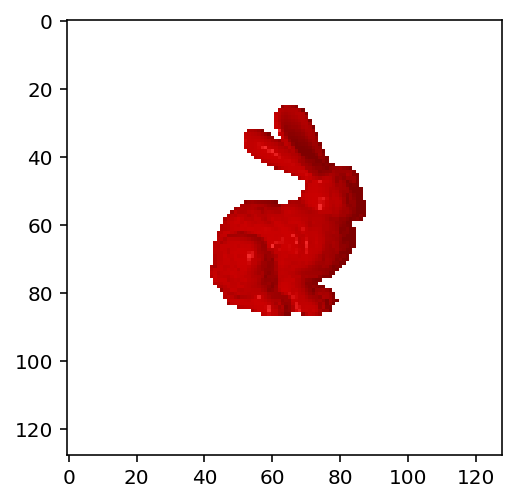

In [ ]:
model_input, gt = next(bunny_dataset) # gt.shape for here is [num_points, 3]

print(model_input.keys())

plt.imshow(gt.view(images.shape[1], images.shape[2], 3).detach().cpu())
plt.show()

Looking good!

## 3.1. Differentiable volume rendering

We're now ready to implement a differentiable renderer.

Specifically, we'll implement a differentiable volume renderer, which is used to render out a radiance field, as proposed in "Neural Radiance Fields" by Mildenhall et al. 2020. For simplicity, we'll implement a version of a radiance field that does not depend on the view direction, i.e., it won't be able to parameterize view-dependent effects (only diffuse materials).

Specifically, then, a radiance field is a function
$$
\Phi: \mathbb{R}^3 \to \mathbb{R}^+ \times \mathbb{R}^3, \quad \Phi(\mathbf{x}) = (\sigma, \mathbf{c})
$$
that maps a 3D coordinate $\mathbf{x}$ to a tuple of emitted radiance $\mathbf{c}$ at that 3D coordinate and local density $\sigma$ at that 3D coordinate.

We could build a Radiance Field on top of _any_ of the 3D representations we have discussed in the previous section! However, as we are limited in terms of compute and memory on Colab, we will resort to the _voxelgrid_ parameterization of the underlying field, which will be fast and relatively cheap (compared to the full neural field parameterization).

Specifically, we will build a radiance field _on top of_ the ground plan class that you implemented above.


In [ ]:
class RadianceField(nn.Module):
    def __init__(self):
        super().__init__()   
        self.scene_rep = HybridVoxelNeuralField(resolution_per_dim=(64,64,64), feature_dim=64, out_dim=64).to(device)
      
        self.sigma = nn.Sequential(nn.ReLU(),
                                   nn.Linear(in_features=64, out_features=1),
                                   nn.ReLU()).to(device)
 
        self.radiance = nn.Sequential(nn.ReLU(inplace=True),
                                   nn.Linear(in_features=64, out_features=3),
                                   nn.Sigmoid()).to(device)
       
        self.sigma.apply(init_weights_normal)
        self.radiance.apply(init_weights_normal)
        ########

    def forward(
        self, 
        xyz: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
      '''
      Queries the representation for the density and color values.
      xyz is a tensor of shape (batch_size, num_samples, 3)
      '''     

      features = self.scene_rep(xyz.to(device))
   
      sigma = self.sigma(features.to(device))
      # print(f'radience field. sigma is cuda: {sigma.is_cuda}')
      rad = self.radiance(features)

      # Return sigma and color.
      ########
      return sigma, rad

Let's test the radiance field by doing a forward pass with random coordinates.

In [ ]:
rad = RadianceField()

test_coords = torch.randn(1, 100, 3)
_ = rad(test_coords)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Great! Now, we'll write a volume renderer that can render the radiance field.

### 3.1.1 Computing world camera rays from camera parameters

We'll first implement a function that, given pixel coordinates, camera intrinsic and the cam2world matrix, returns a tuple of (camera_origins_world, ray_directions_world).


In [ ]:
def get_world_rays(xy_pix: torch.Tensor, 
                   intrinsics: torch.Tensor, #shape = 3,3
                   cam2world: torch.Tensor,
                   ) -> Tuple[torch.Tensor, torch.Tensor]:
    # Get camera origin of camera 1
    # print(f'cam2world: {cam2world.shape}')
    cam_origin_world = cam2world[:, :3 ,-1:].permute(0,2,1) # size should be (batch, 3, 1)
    # print(f'cam_origin_world.shape: {cam_origin_world.shape}')

    # Get ray directions in cam coordinates
    ray_dirs_cam = get_unnormalized_cam_ray_directions(xy_pix, intrinsics) # shape (batch_size,  2)
    # print(ray_dirs_cam.shape)

    # Homogenize ray directions
    rd_cam_hom = homogenize_vecs(ray_dirs_cam) # shape (..., 3)
    # print(rd_cam_hom.shape)

    # Transform ray directions to world coordinates
    rd_world_hom = transform_cam2world(rd_cam_hom, cam2world) 
    # print(rd_world_hom.shape)

    # Tile the ray origins to have the same shape as the ray directions.
    # Currently, ray origins have shape (batch, 3), while ray directions have shape
    cam_origin_world = cam_origin_world[..., :3].clone()

    return cam_origin_world, rd_world_hom[..., :3].clone()
    #######

# check_function("get_world_rays",
#                 get_world_rays,
#                 [torch.tensor([[[0., 0.]]]), #xy_pix 1, 1, 2
#                 torch.tensor([[[0.7, 0., 0.5], #intrinsics  1,3,3
#                                 [0., 0.7, 0.5],
#                                 [0., 0., 1.]]]),
#                 torch.tensor([[[1., 0., 0., 0.],  #cam2world  1,4,4
#                                 [0., 1., 0., 0.],
#                                 [0., 0., 1., 0.],
#                                 [0., 0., 0., 1.]]])], 
#                 [torch.tensor([[[0., 0., 0.]]]), # 1,1,3
#                  torch.tensor([[[-0.7143, -0.7143,  1.0000]]])]) # 1,1,3

### 3.1.2. Sampling points along rays

Next, we'll implement a function that takes a batch of rays as well as a near plane and far plane as input and returns points uniformly sampled in depth between those two planes. 

We will generate a linspace of depth values `z_vals`. We then implement a batched version of the following function to generate points $\mathbf{X}$ with depth $Z$ along rays with origin $\mathbf{r}_o$ and direction $\mathbf{r}_d$:

$$
\mathbf{X}(Z) = \mathbf{r}_o + \mathbf{r}_d * Z
$$

In the function below, we will want to 
Implement that function below:

In [ ]:
def sample_points_along_rays(
    near_depth: float,
    far_depth: float,
    num_samples: int,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
) -> torch.Tensor:
    '''Returns 3D coordinates of points along the camera rays defined by ray_origin
    and ray_directions. Depth values are uniformly sampled between the near_depth and
    the far_depth.

    Parameters:
        near_depth: float. The depth at which we start sampling points.
        far_depth: float. The depth at which we stop sampling points.
        num_samples: int. The number of depth samples between near_depth and far_depth.
        ray_origins: Tensor of shape (batch_size, num_rays, 3). The origins of camera rays. My note: I think
        this should be (batch_size, num_origins, 3) because we have num_rays for each num_origins.
        ray_directions: Tensor of shape (batch_size, num_rays, 3). The directions of camera rays.

    Returns:
        Tuple of (pts, z_vals).
        pts: tensor of shape (batch_size, num_rays, num_samples, 3). 3D points uniformly sampled
                between near_depth and far_depth
        z_vals: tensor of shape (num_samples) of depths linearly spaced between near and far plane.
    ''' 
    # Compute a linspace of num_samples depth values beetween near_depth and far_depth.
    z_vals = torch.linspace(near_depth, far_depth, num_samples)

    # Using the ray_origins, ray_directions, generate 3D points along
    # the camera rays according to the z_vals.

    block = []
    for b in range(len(ray_directions)):
      for z in z_vals:
        block.append((ray_origins[b].clone() + z * ray_directions[b].clone()).tolist()) # (num_rays, 3)

    batch_size = ray_origins.shape[0]
    num_rays = ray_directions.shape[1]

    # print(f'block.shape: {torch.tensor(block).shape}')

    pts = torch.tensor(block).reshape(batch_size, num_rays, num_samples, 3)  

    return pts, z_vals
'''
check_function("sample_points_along_rays", 
               sample_points_along_rays,
               [0.1, 1., 5, torch.tensor([[[0., 0., 0.]]]), torch.tensor([[[0., 0., 1.]]])],
               [torch.tensor([[[0.0000, 0.0000, 0.1000],
                        [0.0000, 0.0000, 0.3250],
                        [0.0000, 0.0000, 0.5500],
                        [0.0000, 0.0000, 0.7750],
                        [0.0000, 0.0000, 1.0000]]]), 
                torch.tensor([0.1000, 0.3250, 0.5500, 0.7750, 1.0000])])
              #  [0.1, 1., 5, torch.tensor([[0., 0., 0.]]), torch.tensor([[0., 0., 1.]])],
              #  [torch.tensor([[[0.0000, 0.0000, 0.1000],
              #           [0.0000, 0.0000, 0.3250],
              #           [0.0000, 0.0000, 0.5500],
              #           [0.0000, 0.0000, 0.7750],
              #           [0.0000, 0.0000, 1.0000]]]),
              #  torch.tensor([0.1000, 0.3250, 0.5500, 0.7750, 1.0000])])
'''

'\ncheck_function("sample_points_along_rays", \n               sample_points_along_rays,\n               [0.1, 1., 5, torch.tensor([[[0., 0., 0.]]]), torch.tensor([[[0., 0., 1.]]])],\n               [torch.tensor([[[0.0000, 0.0000, 0.1000],\n                        [0.0000, 0.0000, 0.3250],\n                        [0.0000, 0.0000, 0.5500],\n                        [0.0000, 0.0000, 0.7750],\n                        [0.0000, 0.0000, 1.0000]]]), \n                torch.tensor([0.1000, 0.3250, 0.5500, 0.7750, 1.0000])])\n              #  [0.1, 1., 5, torch.tensor([[0., 0., 0.]]), torch.tensor([[0., 0., 1.]])],\n              #  [torch.tensor([[[0.0000, 0.0000, 0.1000],\n              #           [0.0000, 0.0000, 0.3250],\n              #           [0.0000, 0.0000, 0.5500],\n              #           [0.0000, 0.0000, 0.7750],\n              #           [0.0000, 0.0000, 1.0000]]]),\n              #  torch.tensor([0.1000, 0.3250, 0.5500, 0.7750, 1.0000])])\n'

### 3.1.3. Computing the volume integral

Finally, we will write a function that computes the volume integral given the depth values, the sigmas, and the radiance values along the rays.

The function below takes as input the $\sigma_i$ and $\mathbf{c}_i$ of points along the rays (i.e., what you get when you sample the radiance field at points along the rays).

You will first compute the $\alpha_i$ as follows:
$$
    \alpha_i = 1 - \exp(-\sigma_i \delta_i)
$$
Where $\delta_i$ is the deltas in depth between points $i$ and $i+1$, and $\sigma_i$ is the density of the $i$-th point. You will compute the $\delta_i$ directly from the $z_{vals}$.

You will then compute the transmittance as follows:
$$
    T_i = \prod_{j=1}^{i-1} (1 - \alpha_j)
$$

Given transmittance and alphas, you can then compute weights $w_i$ as follows:
$$
w_i = \alpha_i T_i
$$

You can then compute the expected radiance along the ray as:
$$
\mathbf{c} = \Sigma_{i=1}^n w_i \mathbf{c}_i
$$

And the expected depth as:
$$
d = \Sigma_{i=1}^n w_i Z_i
$$

In [ ]:
def volume_integral(
    z_vals: torch.tensor,
    sigmas: torch.tensor,
    radiances: torch.tensor
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    '''Computes the volume rendering integral.

    Parameters:
        z_vals: tensor of shape (num_samples) of depths linearly spaced between near and far plane.
        sigmas: tensor of shape (batch_size, num_rays, num_samples, 1). Densities 
            of points along rays.
        radiances: tensor of shape (batch_size, num_rays, num_samples, 3). Emitted
            radiance of points along rays.

    Returns:
        Tuple of (rgb, depth_map, weights).
        rgb: Tensor of shape (batch_size, num_rays, 3). Total radiance observed by rays.
            Computed of weighted sum of radiances along rays.
        depth_map: Tensor of shape (batch_size, num_rays, 1). Expected depth of each ray.
            Computed as weighted sum of z_vals along rays.
    '''
    # Compute the deltas in depth between the points.
    # i'm assuming all distances are the same. 
    dists = ((z_vals[-1].clone()-z_vals[0].clone())/(len(z_vals)-1)).repeat(len(z_vals))# len(dists) = len(z_vals) 
    dists[-1] = 0

    # Compute the alpha values from the densities and the dists.
    sigmas_dists_mul = torch.einsum('bijk, j -> bijk', sigmas, dists.to(device))
    alpha = 1- torch.exp(-sigmas_dists_mul) # alpha.shape = (batch_size, num_rays, num_samples, 1)

    # Compute the Ts from the alpha values. Use torch.cumprod.
    Ts = torch.cumprod(1-alpha, dim=2) # Ts.shape = (batch_size, num_rays, num_samples, 1)

    # Compute the weights from the Ts and the alphas.
    weights = (alpha * Ts) # weights.shape = (batch_size, num_rays, num_samples, 1)
    
    # Compute the pixel color as the weighted sum of the radiance values.
    
    rgb = torch.sum(weights * radiances, dim=2) # radiances = (batch_size, num_rays, num_samples, 3)..   

    # Compute the depths as the weighted sum of z_vals.
    depth_map = torch.sum(torch.einsum('bijk, j -> bijk', weights, z_vals.to(device)), dim=2)

    return rgb, depth_map, weights

# check_function("volume_integral",
#                 volume_integral,
#                 [torch.linspace(0.1, 1, 5), 
#                  torch.linspace(1., 1.5, 5).reshape(1, 1, -1, 1), 
#                  torch.stack([torch.linspace(1., 1.5, 5) for _ in range(3)]).permute(1, 0).reshape(1, 1, -1, 3)],
#                 [torch.tensor([[[0.5859, 0.5859, 0.5859]]]), # rgb
#                  torch.tensor([[[0.1951]]]), # depth_map
#                  torch.tensor([[[[1.6089e-01], # weights
#                                  [1.3864e-01],
#                                  [1.1472e-01],
#                                  [9.1387e-02],
#                                  [3.4344e-11]]]])])

### 3.1.4. Implementing the volume render

Finally, we assemble all the pieces and write the volume renderer! We implement it as a pytorch module to keep track of the near and far planes, and the number of samples.

We also already implemented another trick for you that allows to render with white background.


In [ ]:
class VolumeRenderer(nn.Module):
    def __init__(self, near, far, n_samples=32, white_back=True, rand=False):
        super().__init__()
        self.near = near
        self.far = far
        self.n_samples = n_samples
        self.white_back = white_back
        self.rand = rand

    def unpack_input_dict(self, 
                         input_dict:Dict[str, torch.Tensor]
        ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        c2w = input_dict['cam2world']
        intrinsics = input_dict['intrinsics']
        x_pix = input_dict['x_pix'] # x_pix are query points
        return c2w, intrinsics, x_pix

    def forward(
        self, 
        input_dict: Dict[str, torch.Tensor],
        radiance_field: nn.Module
        ) -> Tuple[torch.tensor, torch.tensor]:
        """
        Takes as inputs ray origins and directions - samples points along the 
        rays and then calculates the volume rendering integral. 

        Params:
            input_dict: Dictionary with keys 'cam2world', 'intrinsics', and 'x_pix'
            radiance_field: nn.Module instance of the radiance field we want to render.

        Returns:
            Tuple of rgb, depth_map
            rgb: for each pixel coordinate x_pix, the color of the respective ray.
            depth_map: for each pixel coordinate x_pix, the depth of the respective ray. 
        """
        cam2world, intrinsics, x_pix = self.unpack_input_dict(input_dict)
         # x_pix.shape = (batch_size, num_rays, 2). but.. 
        batch_size, num_rays = x_pix.shape[0], x_pix.shape[1]
      
        # Compute the ray directions in world coordinates.
        # Use the function get_world_rays.
        # ros (ray origins) = cam origin world coord.  shape = (batch_size, num_rays, 3)
        # we're not doing view dependent. only one camera origin. so cam2world.shape = [1,4,4]
        # rds (ray directions)= ray direction world coord hom. shape = (batch_size, num_rays, 3)
        ros, rds = get_world_rays(x_pix, intrinsics, cam2world)
      
        # Generate the points along rays and their depth values
        # Use the function sample_points_along_rays.
        # pts shape (batch_size, num_rays, num_samples, 3)
        # in this ex, ros shape = (1,3), rds shape = (1, 16384, 3)
        pts, z_vals = sample_points_along_rays(self.near, self.far, self.n_samples, ros, rds)

        # if self.rand:
        #     pts[..., -1:] += torch.rand_like(pts[..., -1:]) * (self.far-self.near)/self.n_samples

        # Reshape pts to (batch_size, -1, 3).
        pts = pts.reshape(batch_size, -1, 3)

        # Sample the radiance field with the points along the rays.
        # radiance_field will infer sigma (density) and radiance for each sample point for each ray
        # radiance_field is basically a info box of scene; it knows/infers how given scene looks like
        sigma, rad = radiance_field(pts)

        # Reshape sigma and rad back to (batch_size, num_rays, self.n_samples, -1)
        sigma = sigma.reshape(batch_size, num_rays, self.n_samples, -1)
        rad = rad.reshape(batch_size, num_rays, self.n_samples, -1)

        # Compute pixel colors, depths, and weights via the volume integral.
        rgb, depth_map, weights = volume_integral(z_vals, sigma, rad)
      
        if self.white_back:
            accum = weights.sum(dim=-2)
            rgb = rgb + (1. - accum)

        return rgb, depth_map

Let's test it:

In [ ]:
rad = RadianceField().to(device)
renderer = VolumeRenderer(near=0.1, far=5., n_samples=32, white_back=True).to(device)

In [ ]:
test_inp, _ = next(bunny_dataset)
renderer(test_inp, rad)

(tensor([[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]], grad_fn=<AddBackward0>), tensor([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]], grad_fn=<SumBackward1>))

### 3.1.5 Fitting the Bunny radiance field




In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def to_gpu(ob):
    if isinstance(ob, collections.Mapping):
        return {k: to_gpu(v) for k, v in ob.items()}
    elif isinstance(ob, tuple):
        return tuple(to_gpu(k) for k in ob)
    elif isinstance(ob, list):
        return [to_gpu(k) for k in ob]
    else:
        try:
            return ob.cuda()
        except:
            return ob


def fit_inverse_graphics_representation(representation,
                                        renderer, 
                                        data_iter,
                                        img_resolution,
                                        total_steps=2001,
                                        lr=1e-4
                                        ):  
    steps_til_summary = 100

    optim = torch.optim.Adam(lr=lr, params=representation.parameters())

    losses = []
    for step in range(total_steps):
        # Get the next batch of data and move it to the GPU
        cam_params, ground_truth = next(data_iter)
        cam_params = to_gpu(cam_params)
        ground_truth = to_gpu(ground_truth)

        # Compute the MLP output for the given input data and compute the loss
        with torch.enable_grad(): # added this
          rgb, depth = renderer(cam_params, representation)

        loss = ((rgb- ground_truth) ** 2).mean()

        # Accumulate the losses so that we can plot them later
        losses.append(loss.detach().cpu().numpy())

        # Every so often, we want to show what our model has learned.
        if not step % steps_til_summary:
            print(f"Step {step}: loss = {float(loss.detach().cpu()):.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(18, 6), squeeze=False)
            axes[0, 0].imshow(rgb.cpu().view(*img_resolution).detach().numpy())
            axes[0, 0].set_title("Trained MLP")
            axes[0, 1].imshow(ground_truth.cpu().view(*img_resolution).detach().numpy())
            axes[0, 1].set_title("Ground Truth")
            
            depth = depth.cpu().view(*img_resolution[:2]).detach().numpy()
            axes[0, 2].imshow(depth, cmap='Greys')
            axes[0, 2].set_title("Depth")
            
            for i in range(3):
                axes[0, i].set_axis_off()

            plt.show()

        optim.zero_grad()
        loss.backward()
        optim.step()

    fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=False)
    axes[0, 0].plot(np.array(losses))
    plt.show()

In [ ]:
rf = RadianceField().to(device) # was .cuda()
renderer = VolumeRenderer(near=1.5, far=4.5, n_samples=128, white_back=True, rand=False).to(device) # was .cuda()

<ipython-input-77-ce94e6877a24>:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(ob, collections.Mapping):


Step 0: loss = 0.06


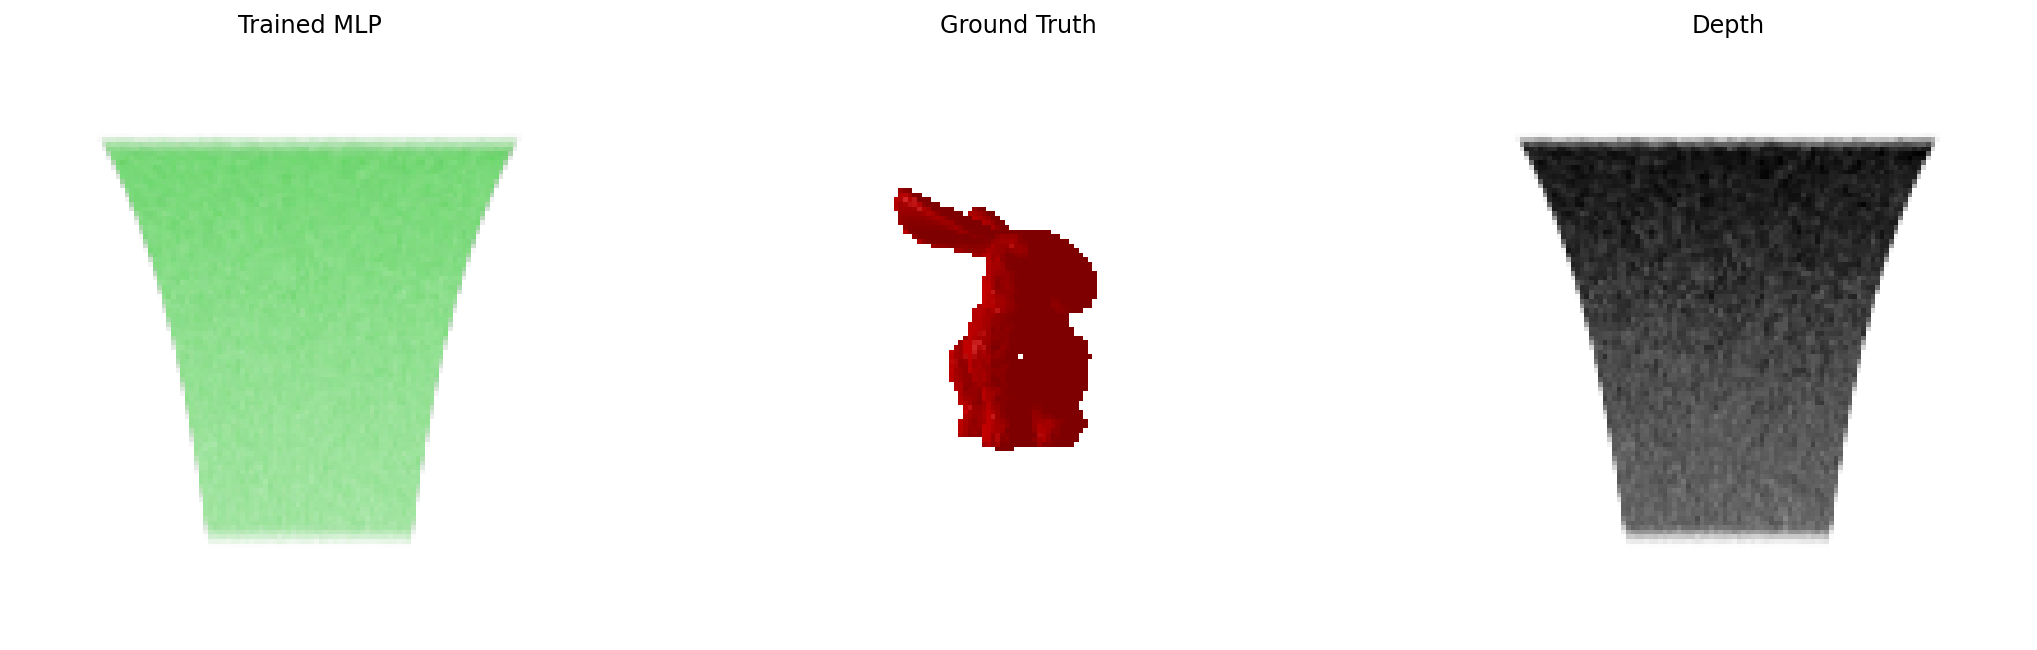

Step 100: loss = 0.02


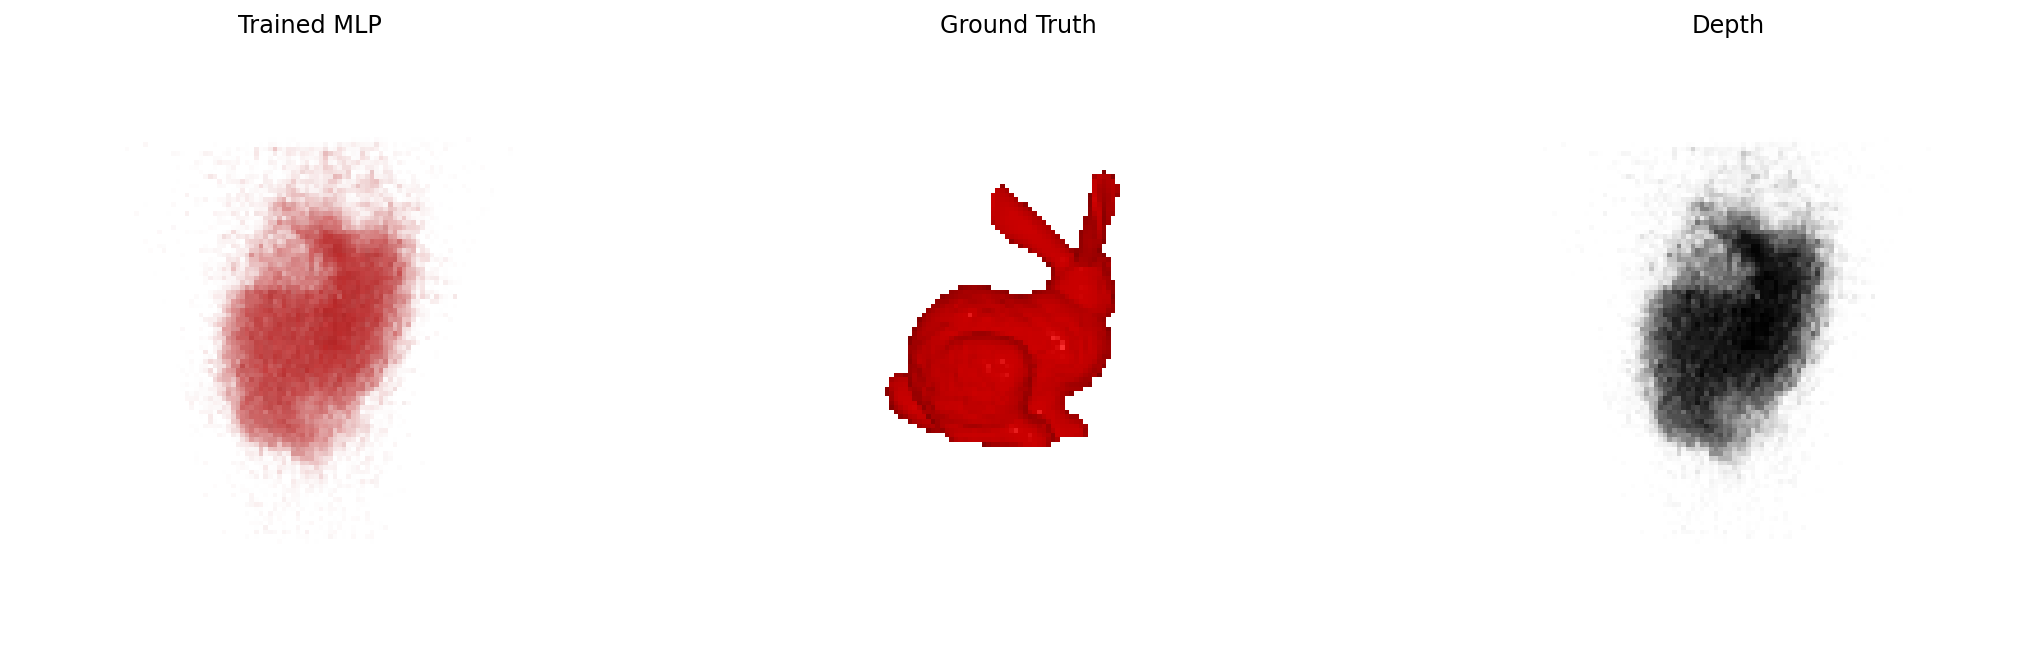

Step 200: loss = 0.02


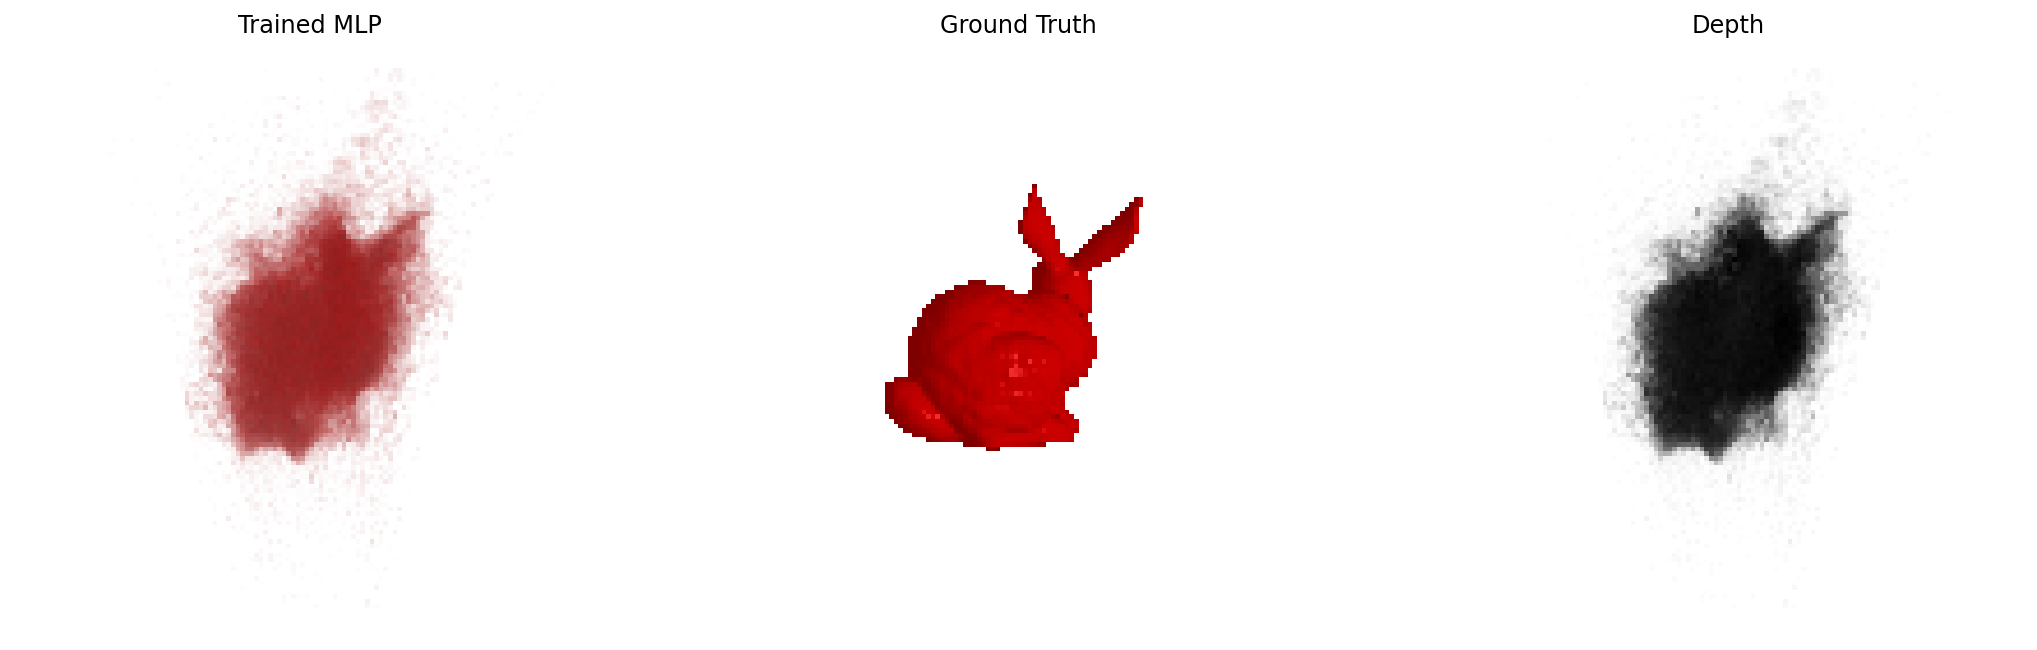

Step 300: loss = 0.02


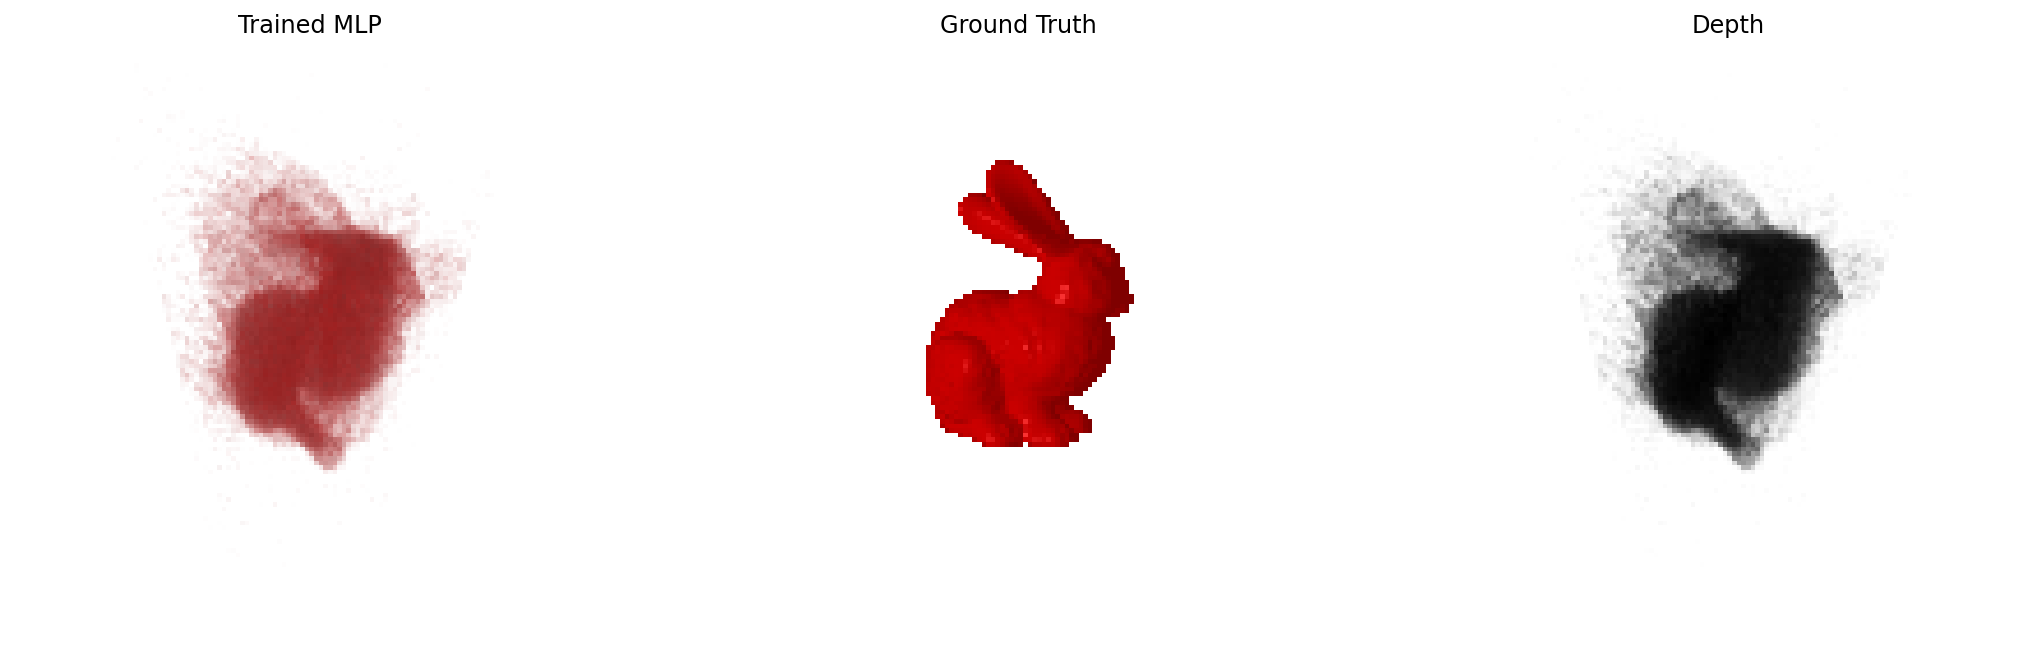

Step 400: loss = 0.01


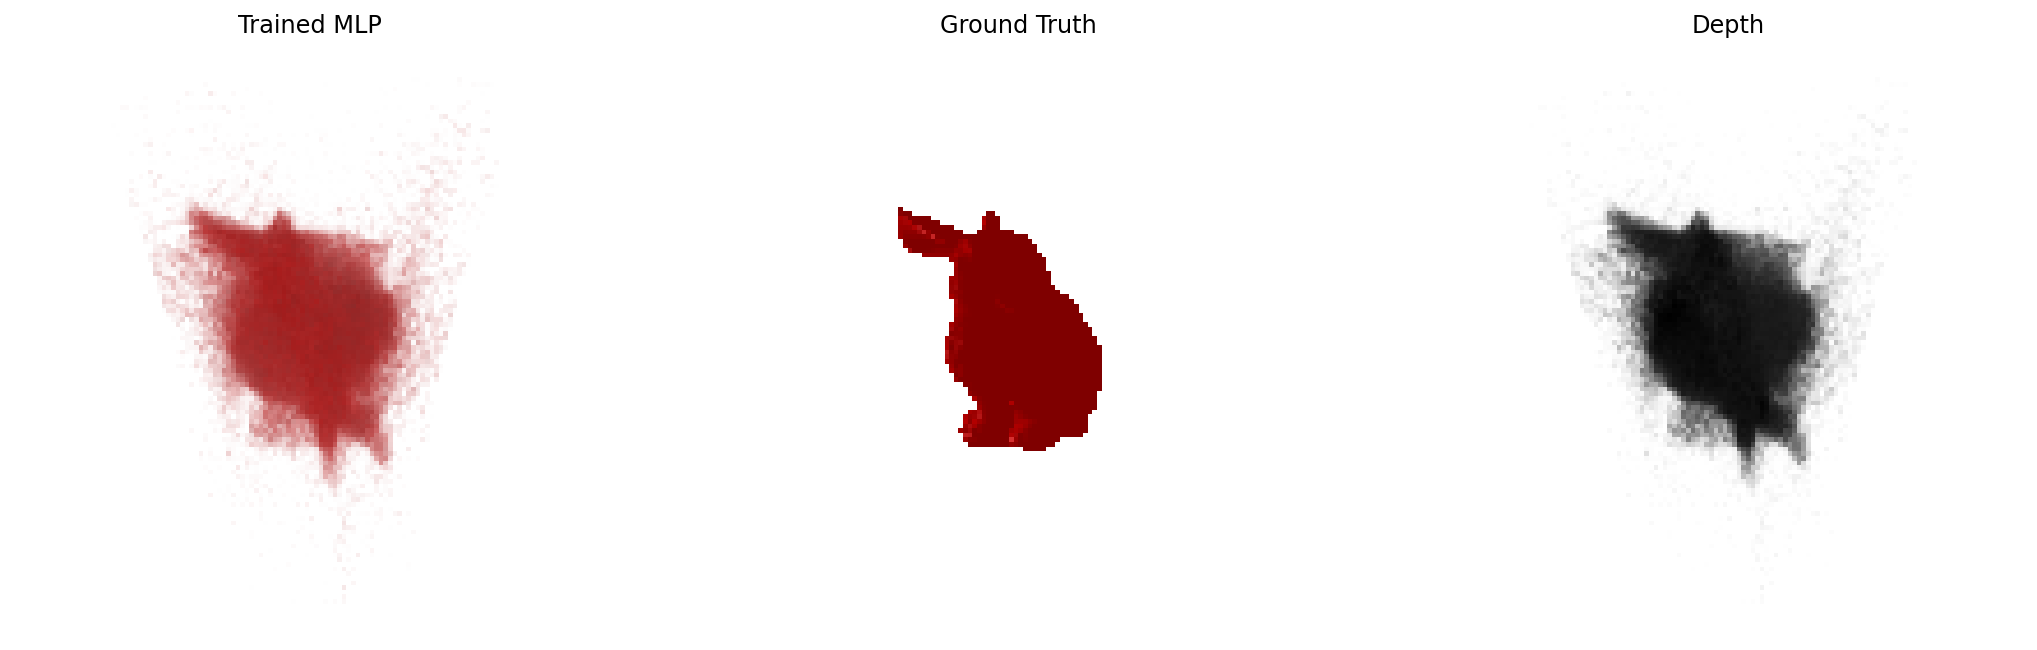

Step 500: loss = 0.02


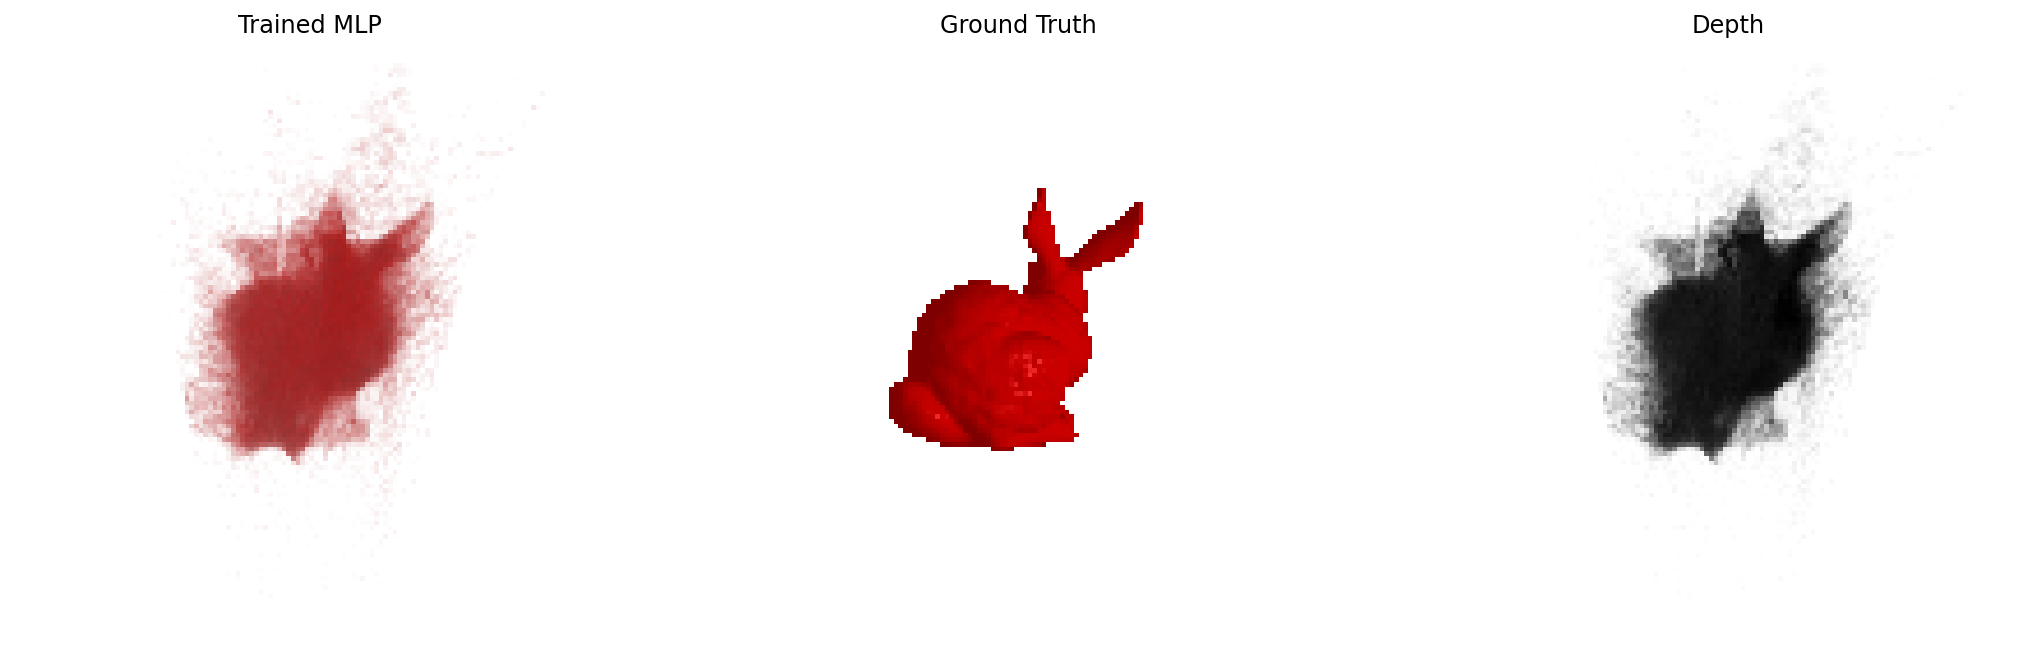

Step 600: loss = 0.02


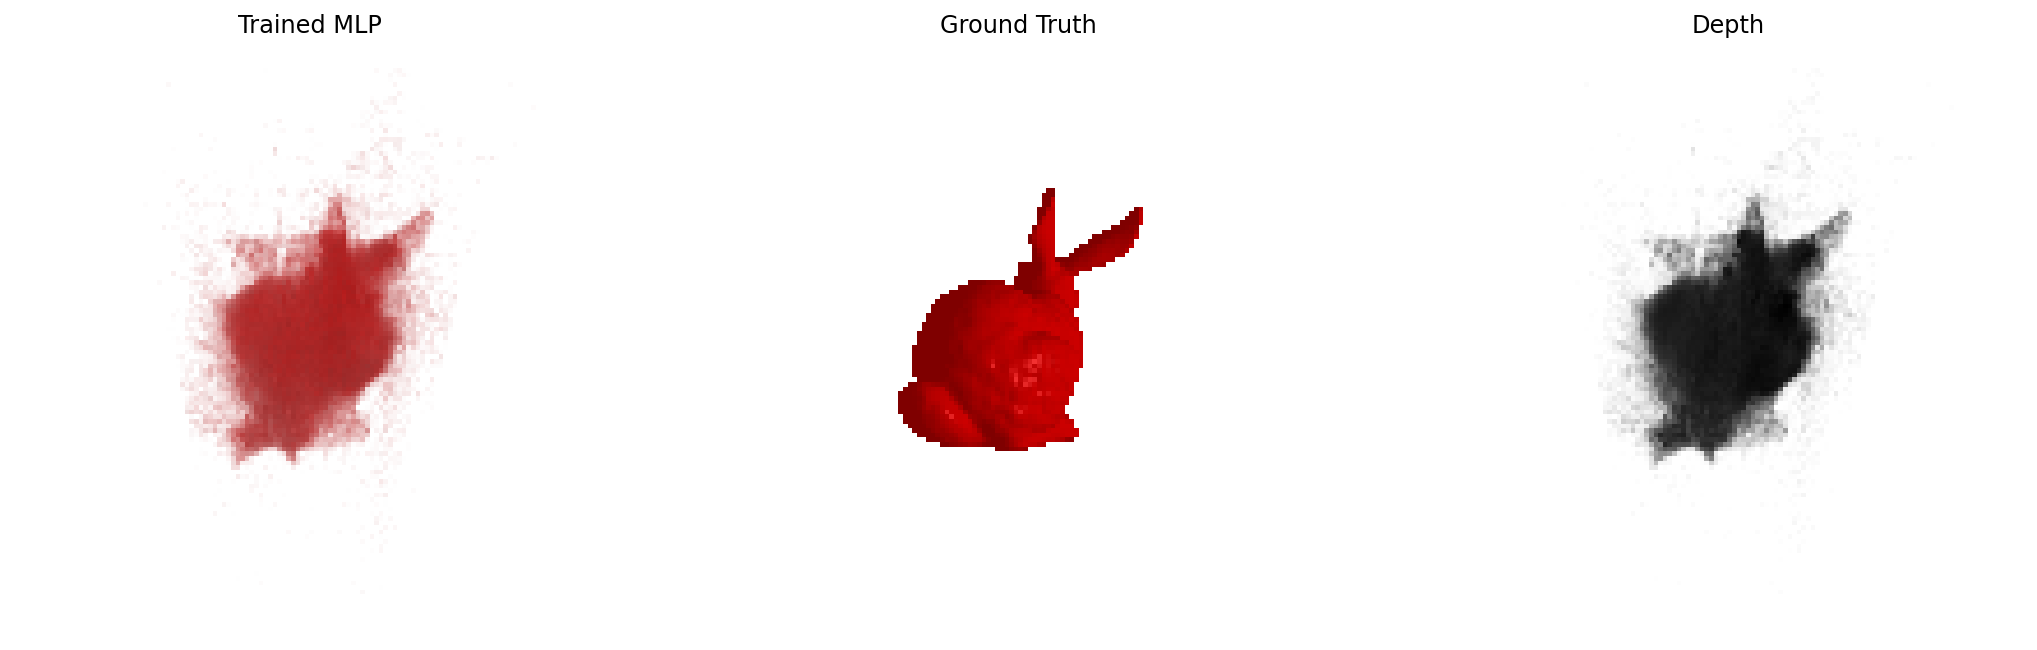

Step 700: loss = 0.02


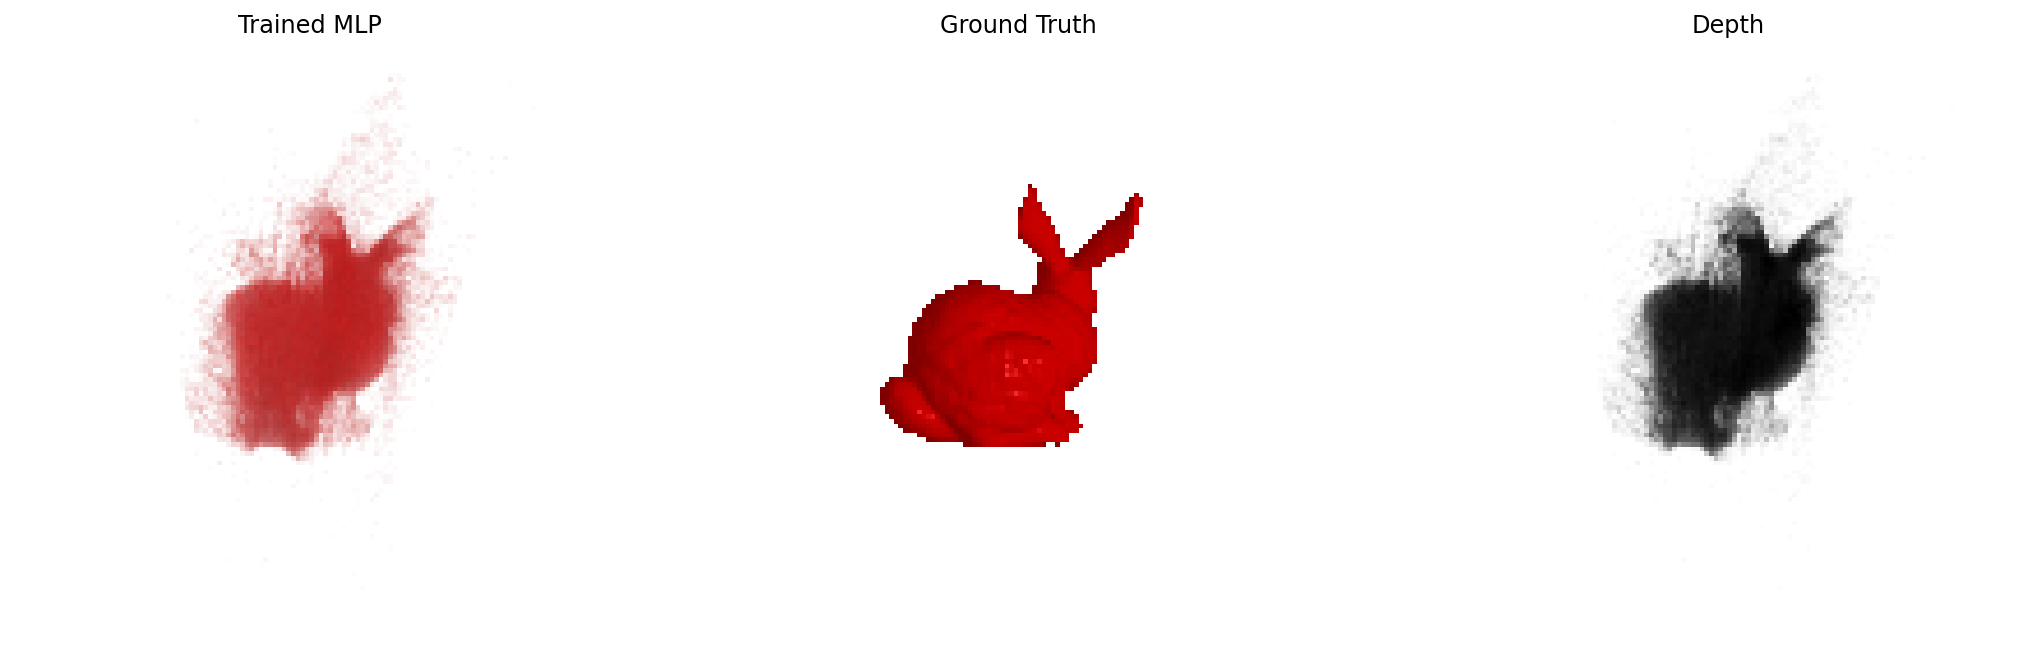

Step 800: loss = 0.02


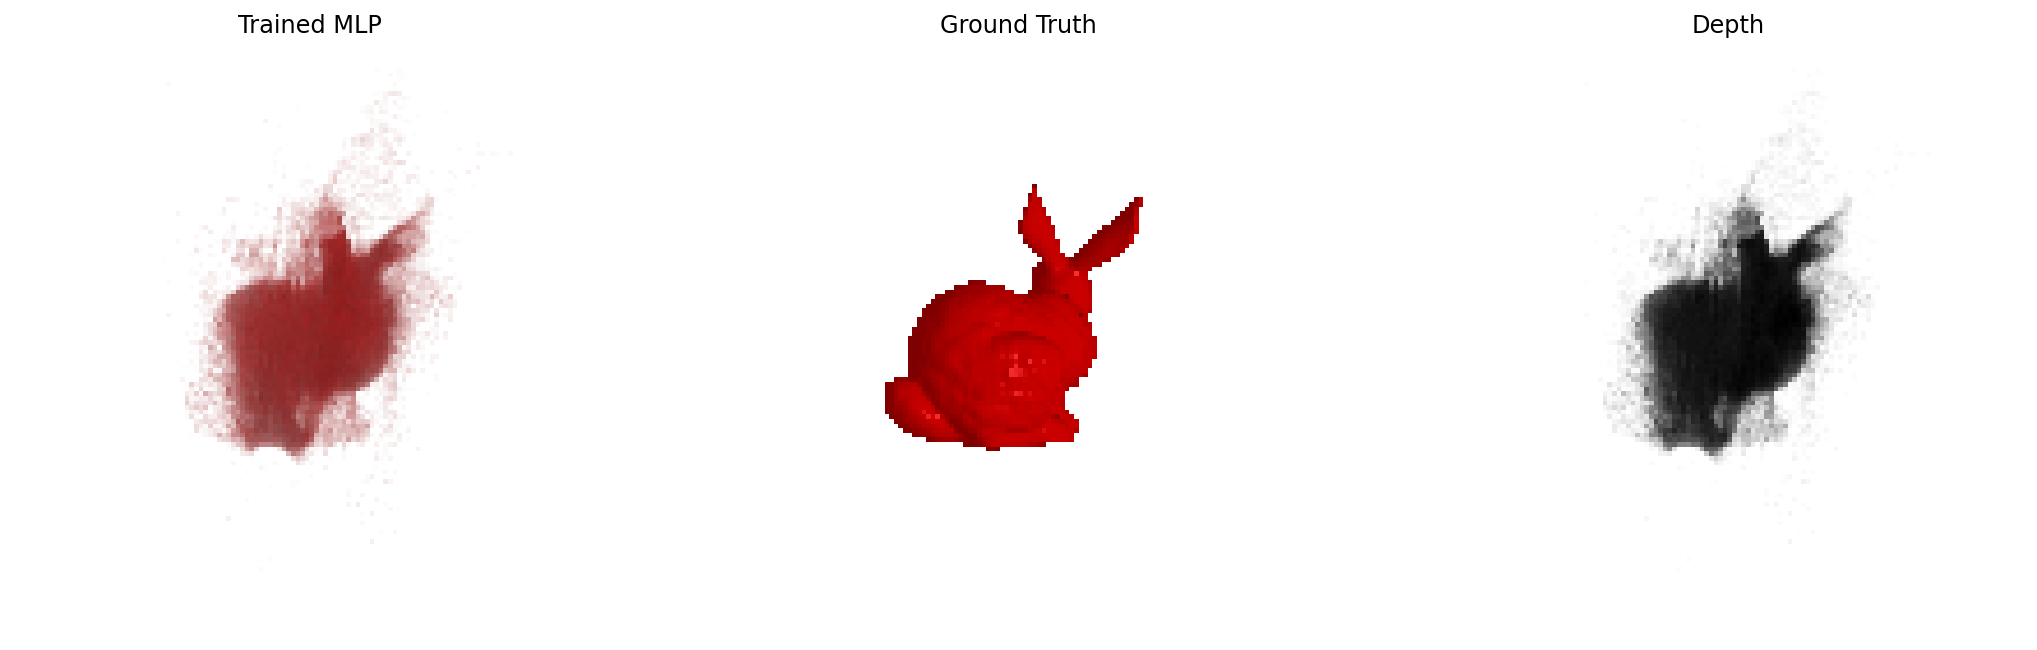

Step 900: loss = 0.02


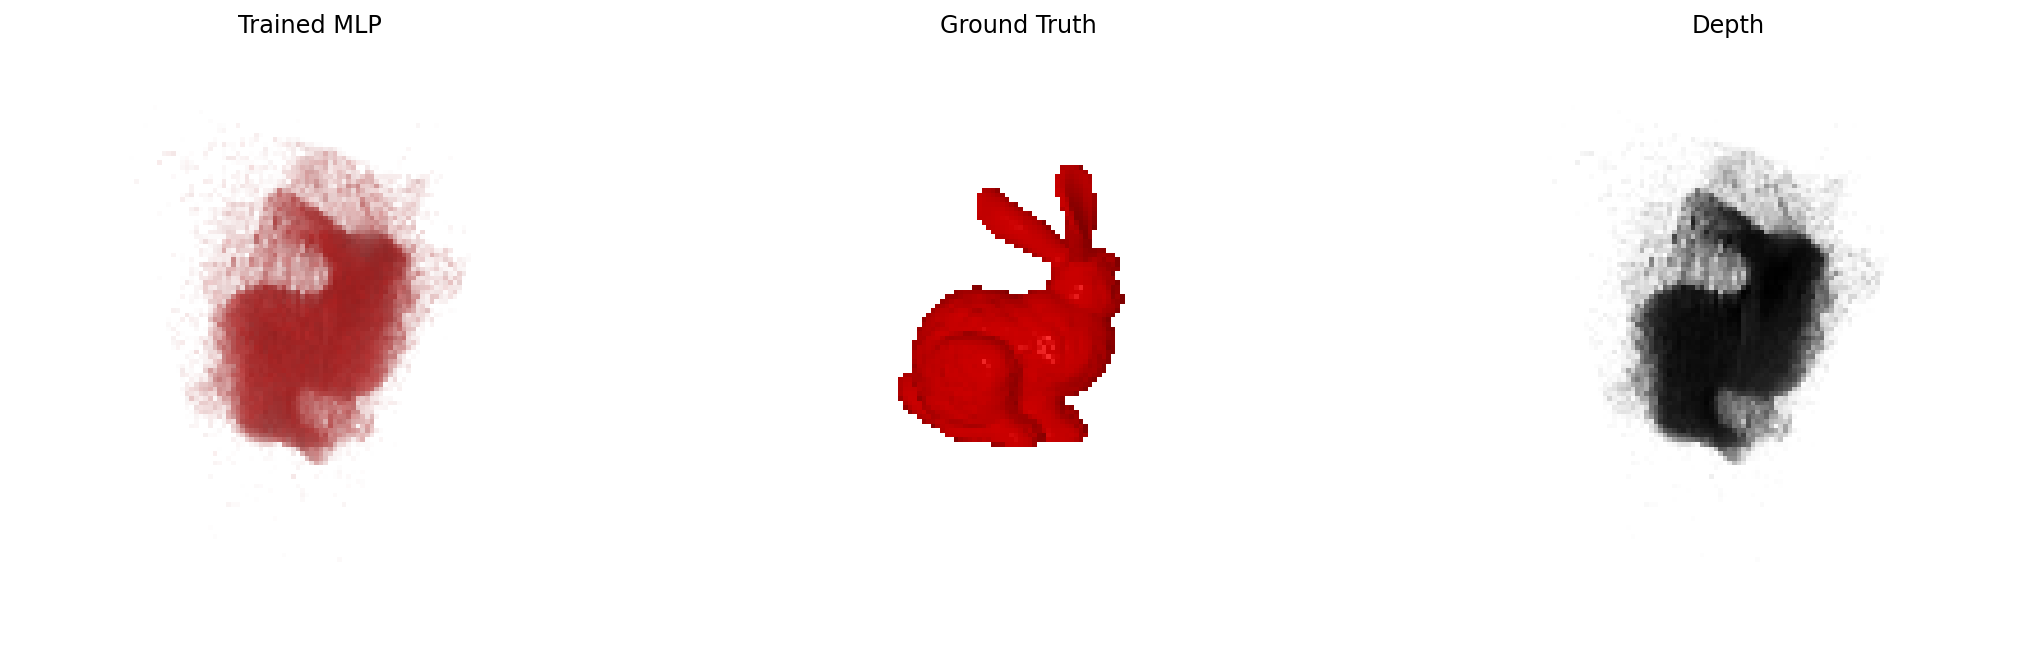

Step 1000: loss = 0.01


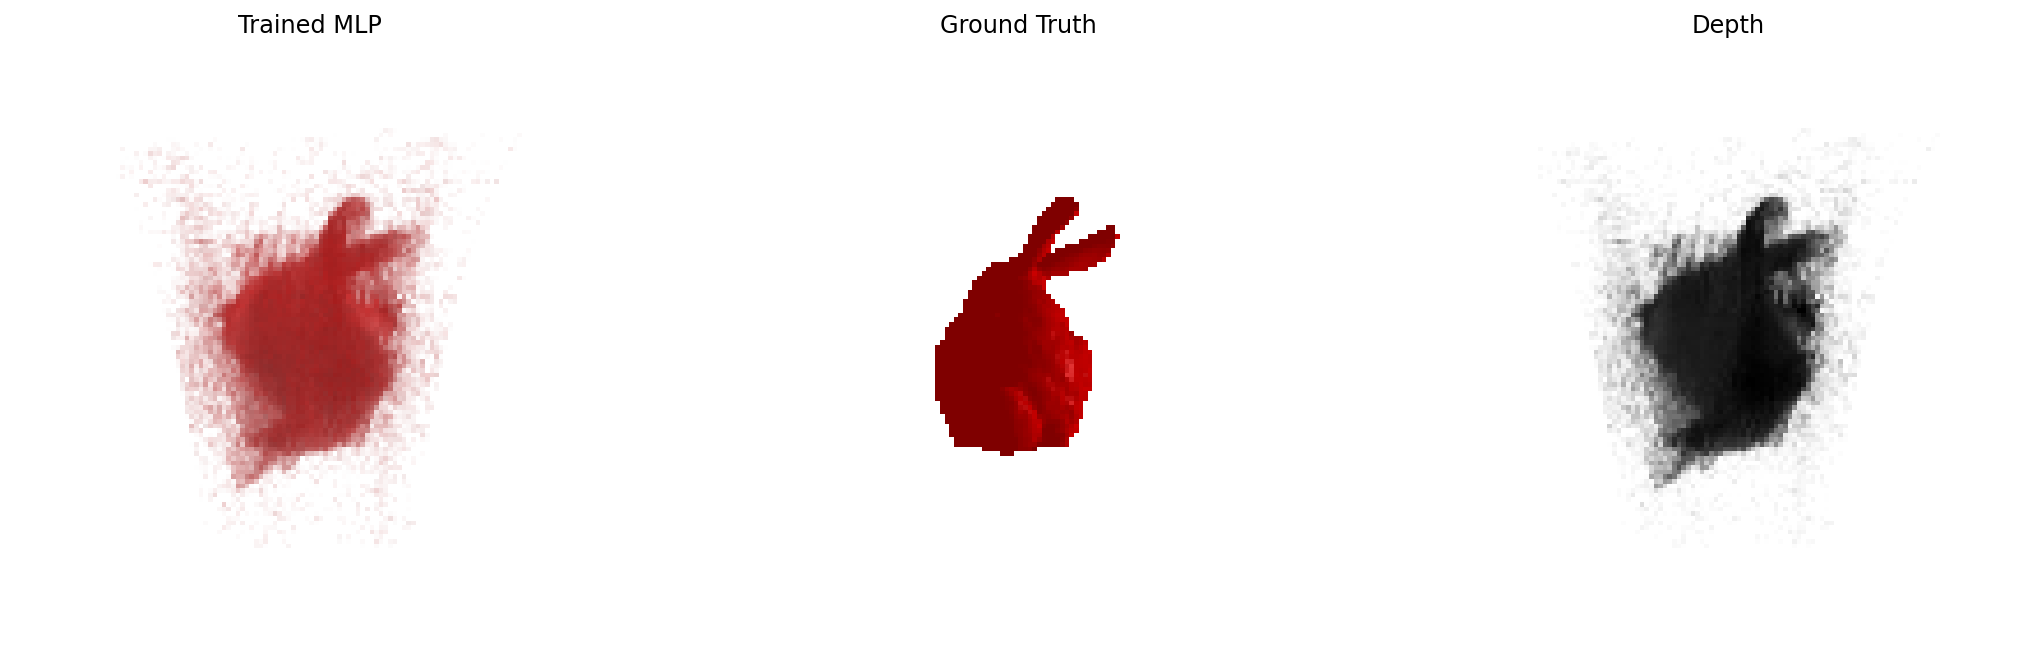

Step 1100: loss = 0.01


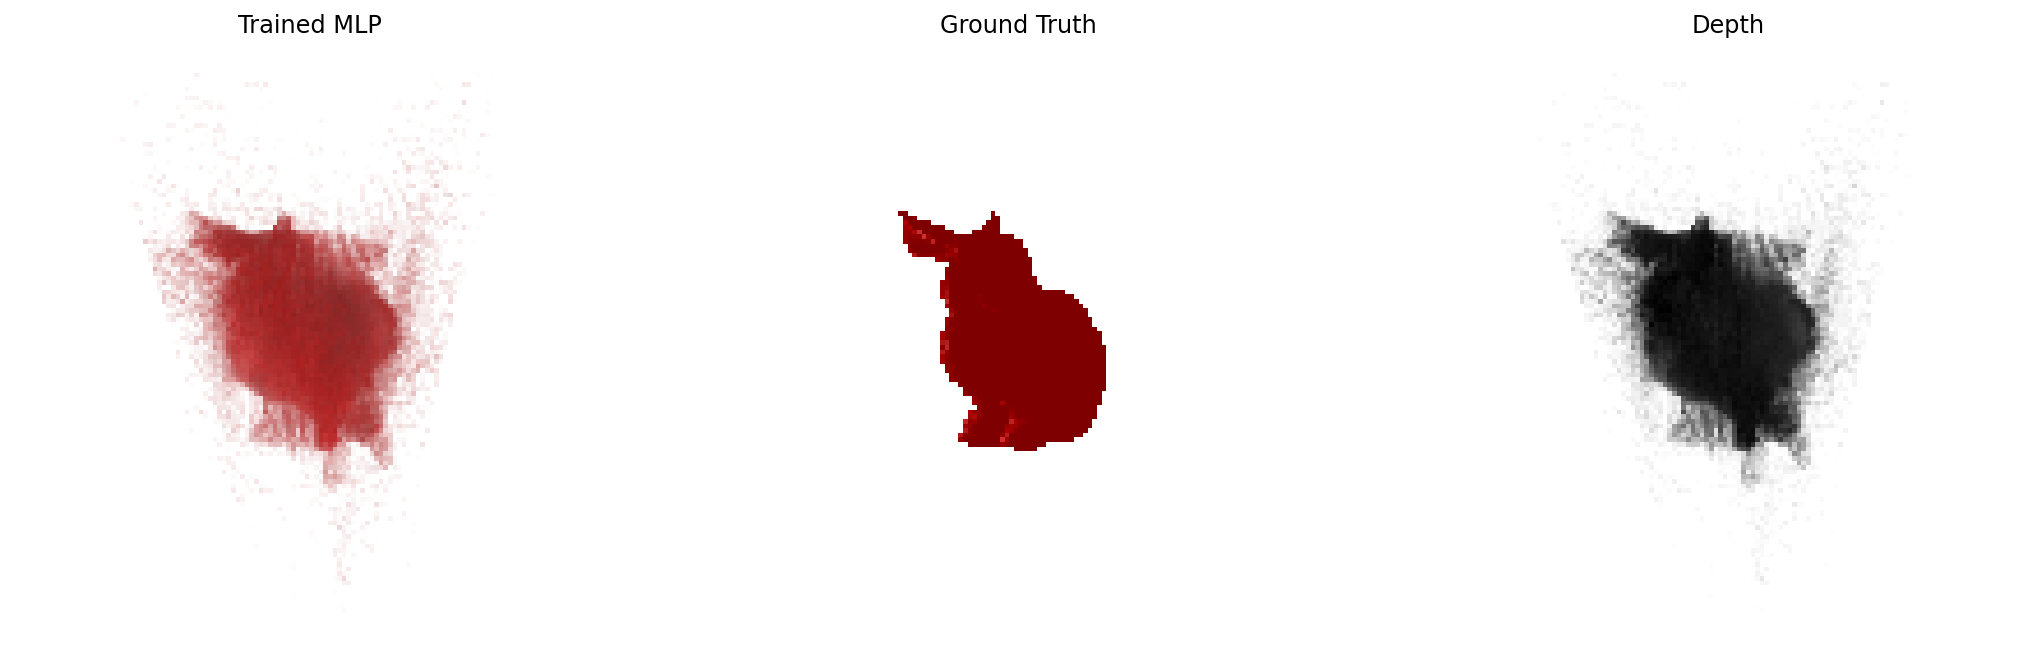

Step 1200: loss = 0.02


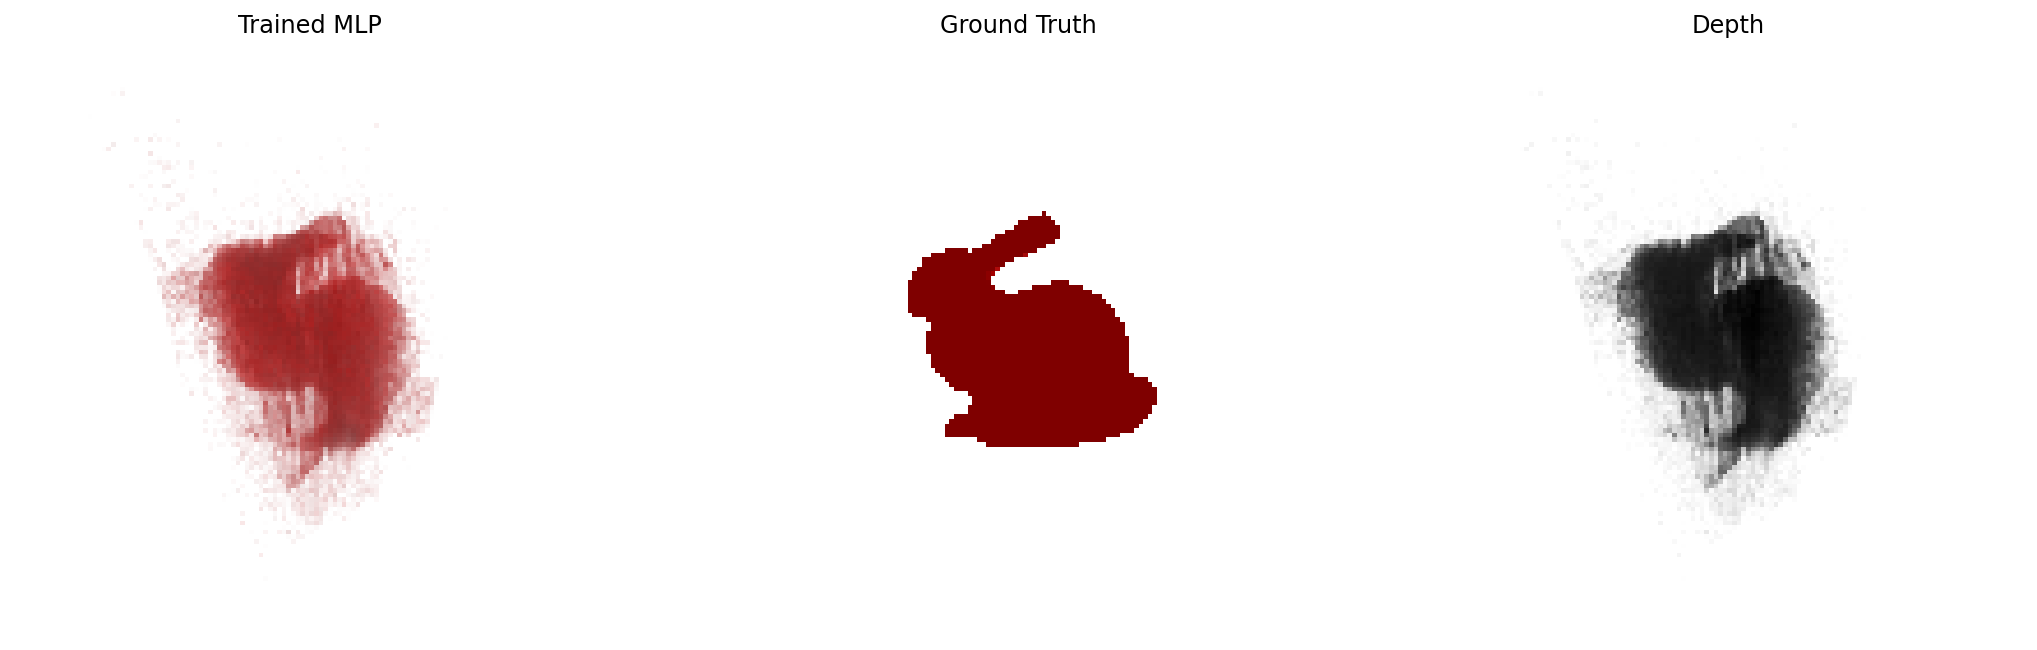

Step 1300: loss = 0.01


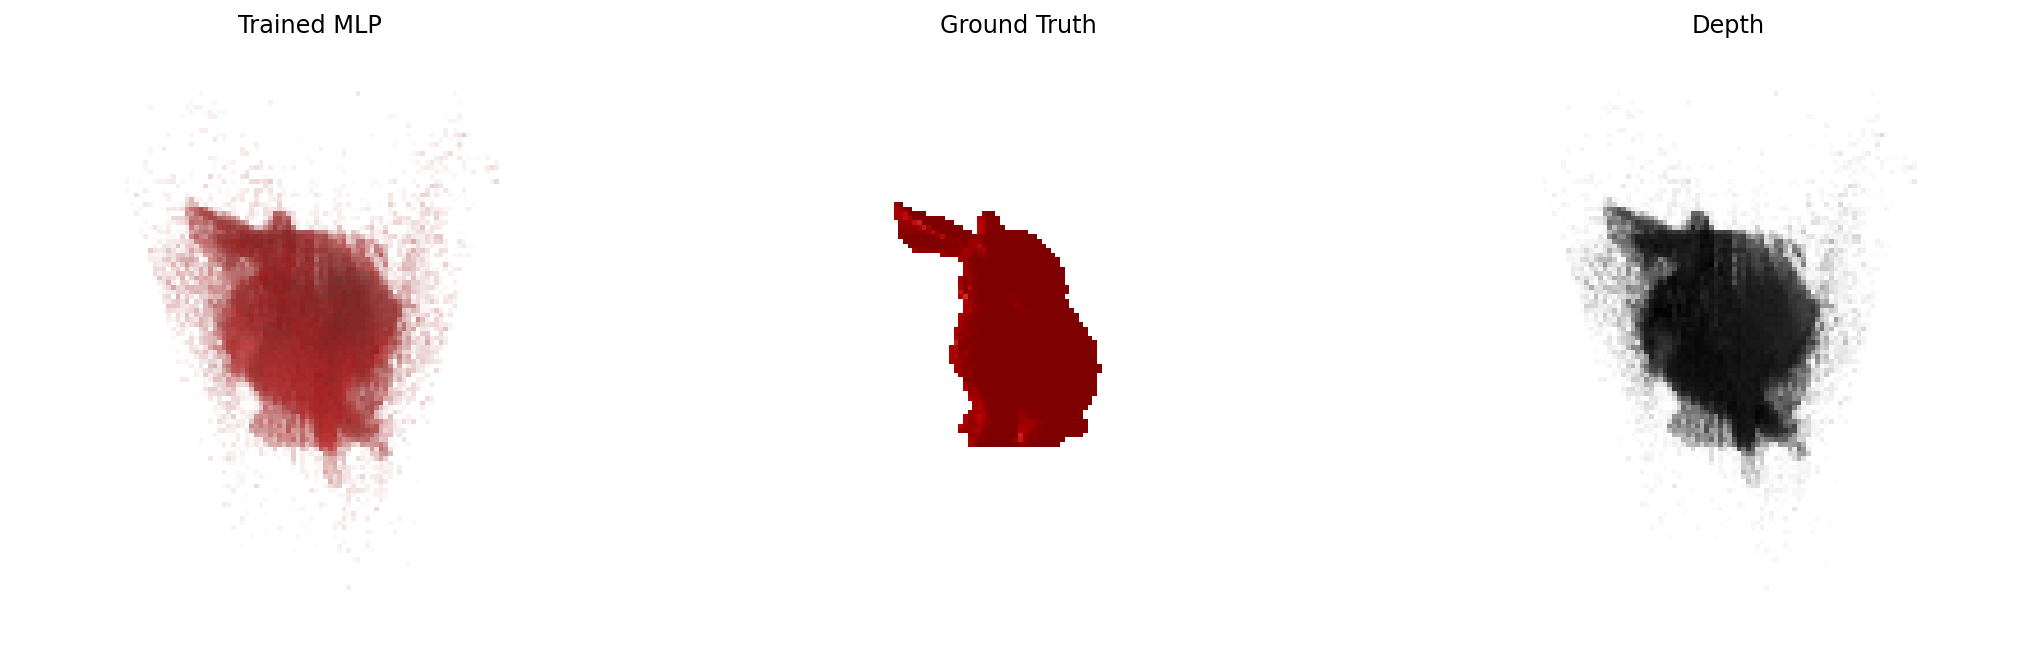

Step 1400: loss = 0.02


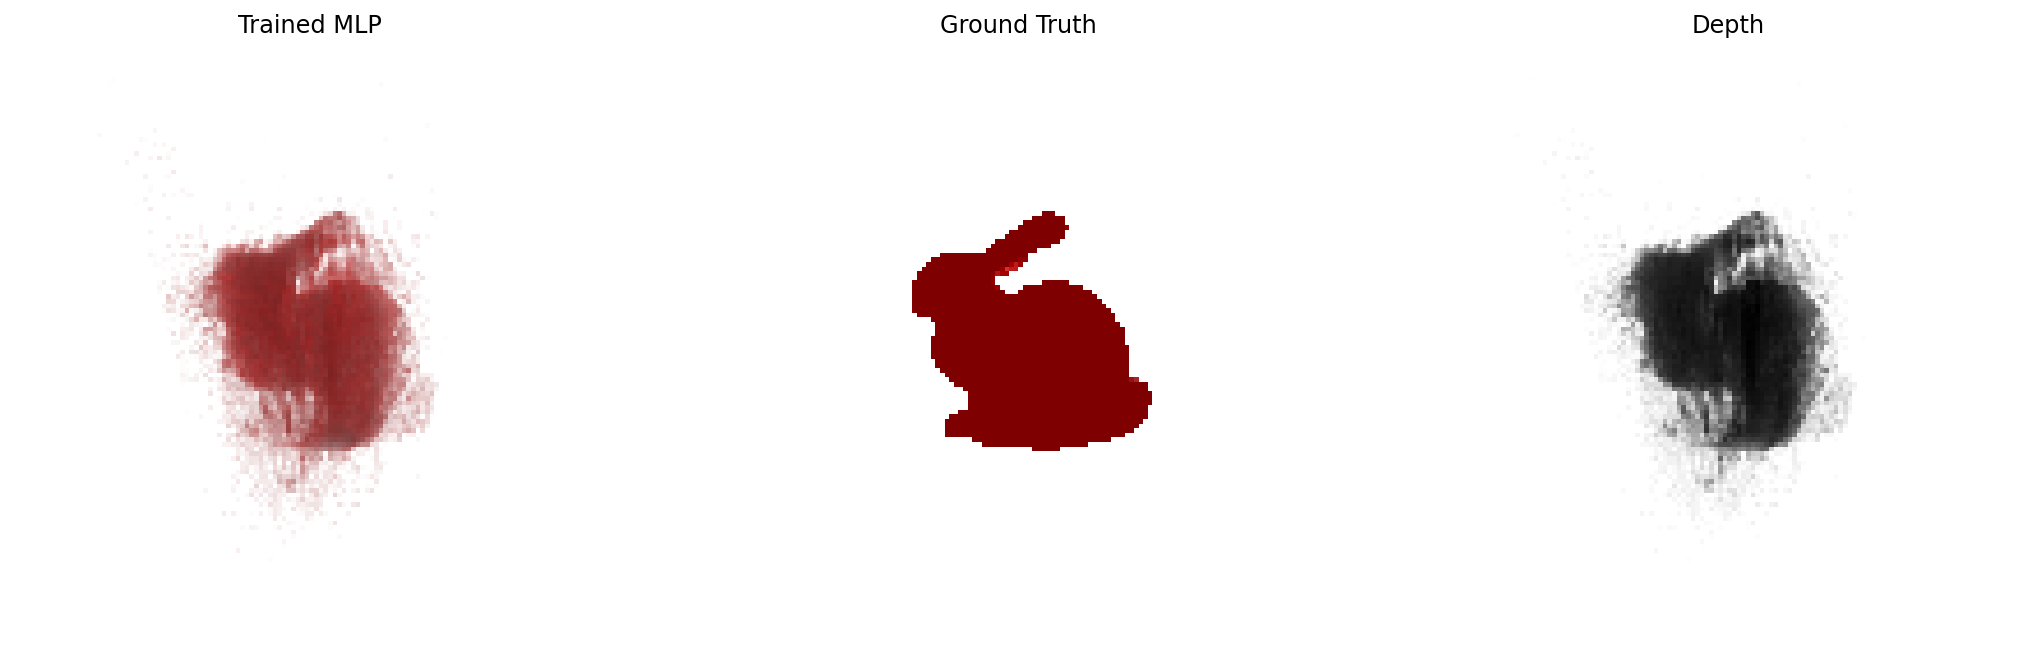

Step 1500: loss = 0.01


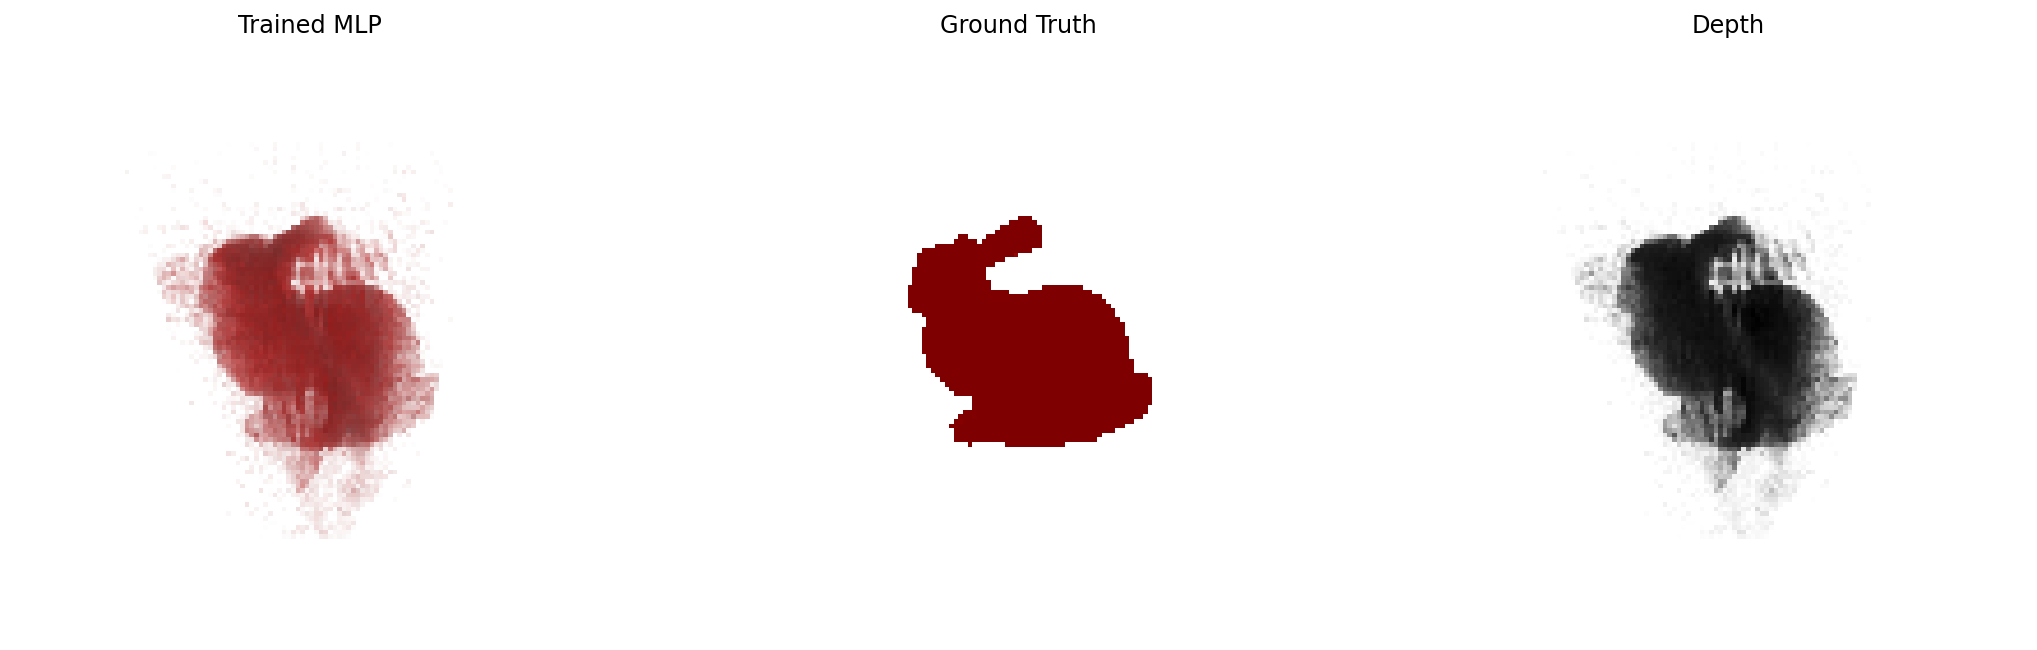

Step 1600: loss = 0.01


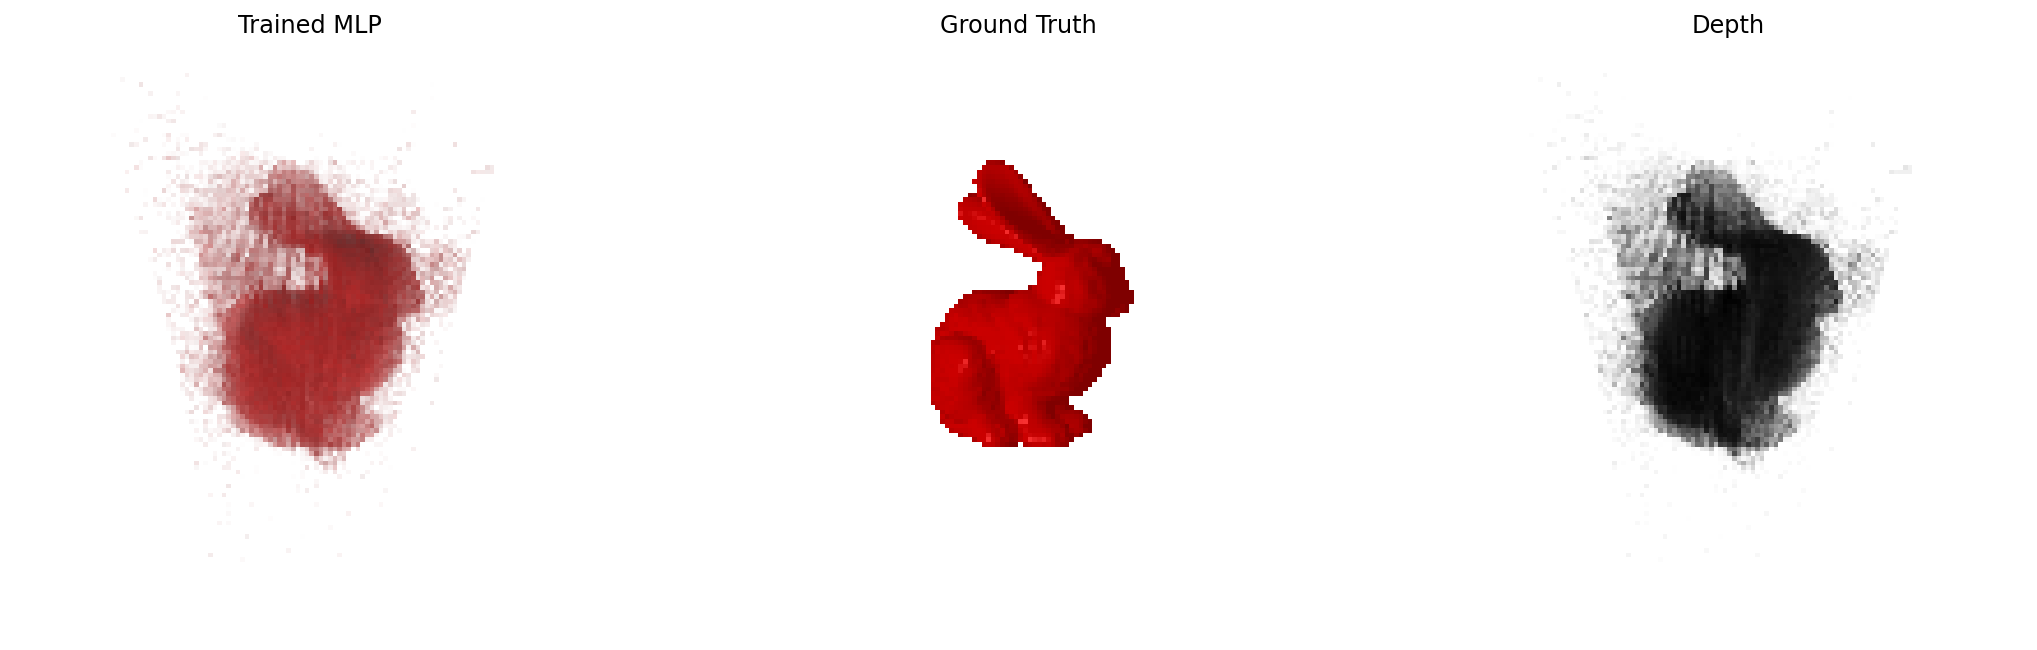

Step 1700: loss = 0.01


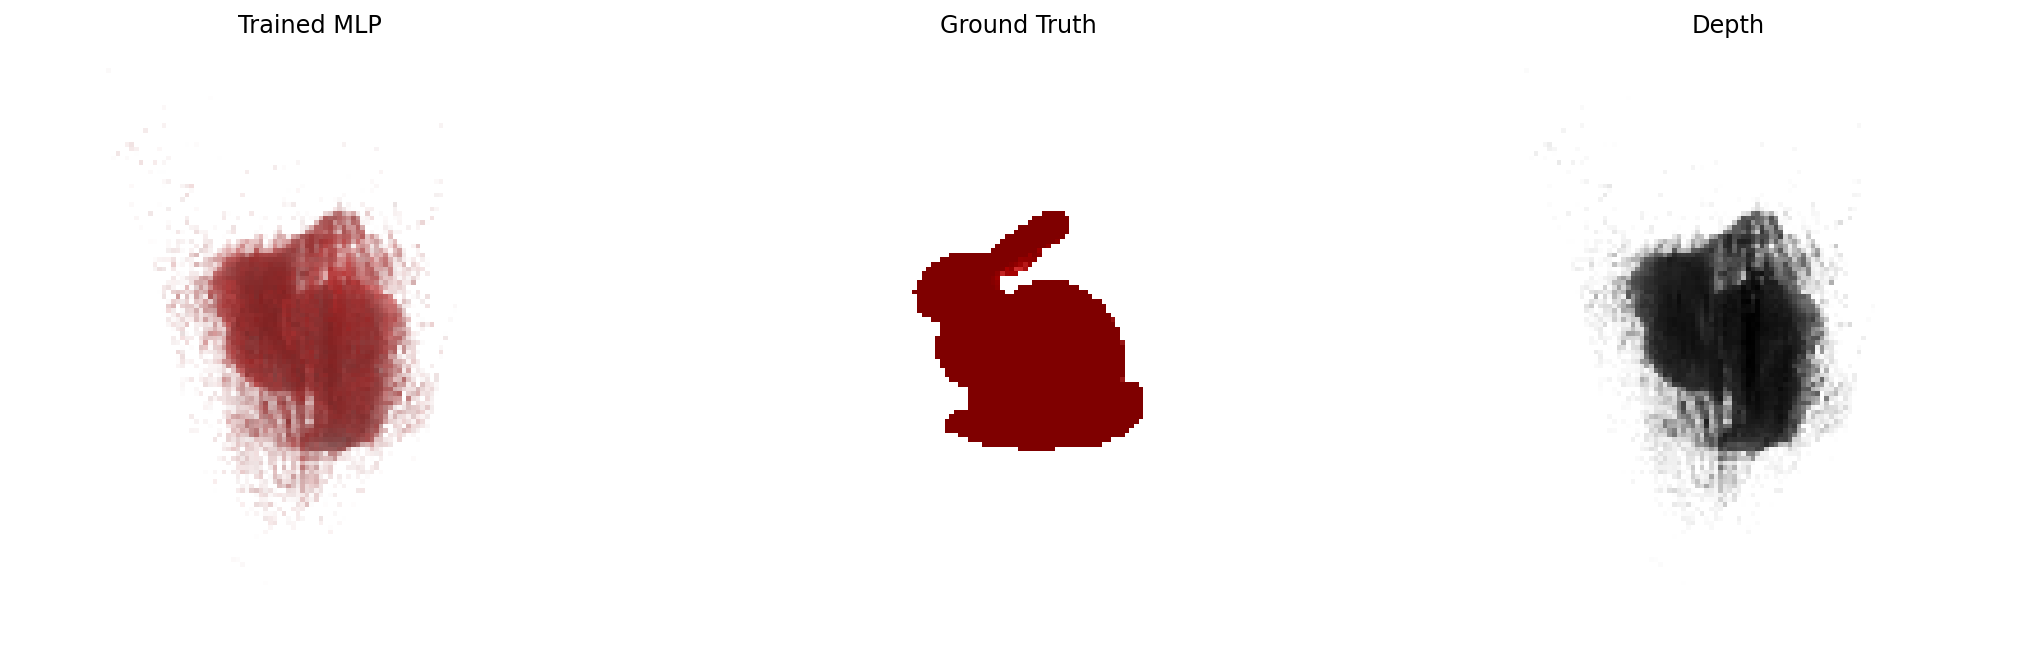

Step 1800: loss = 0.01


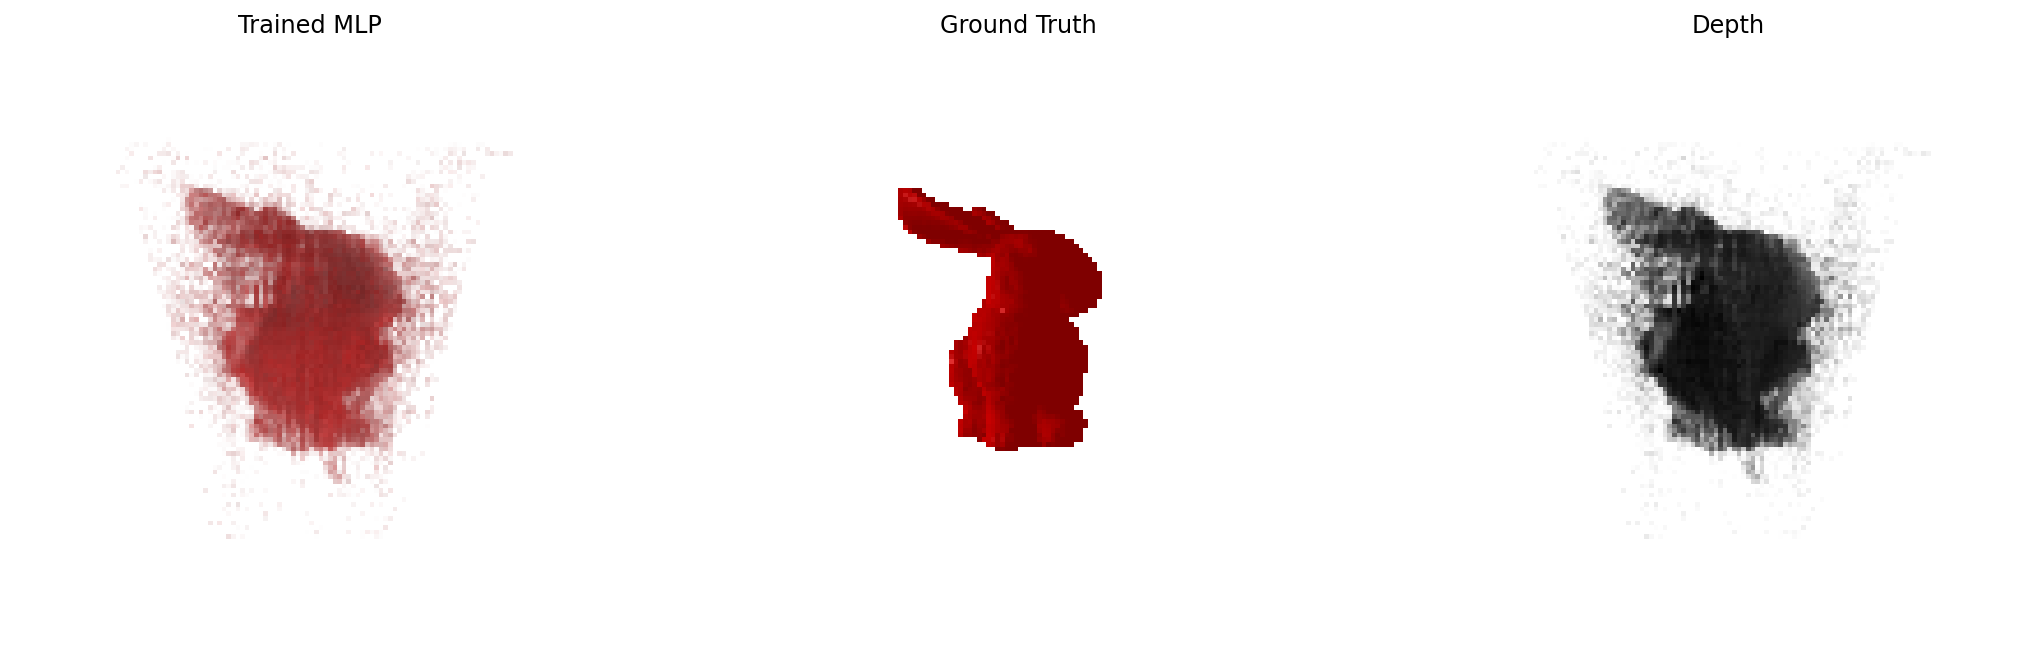

Step 1900: loss = 0.01


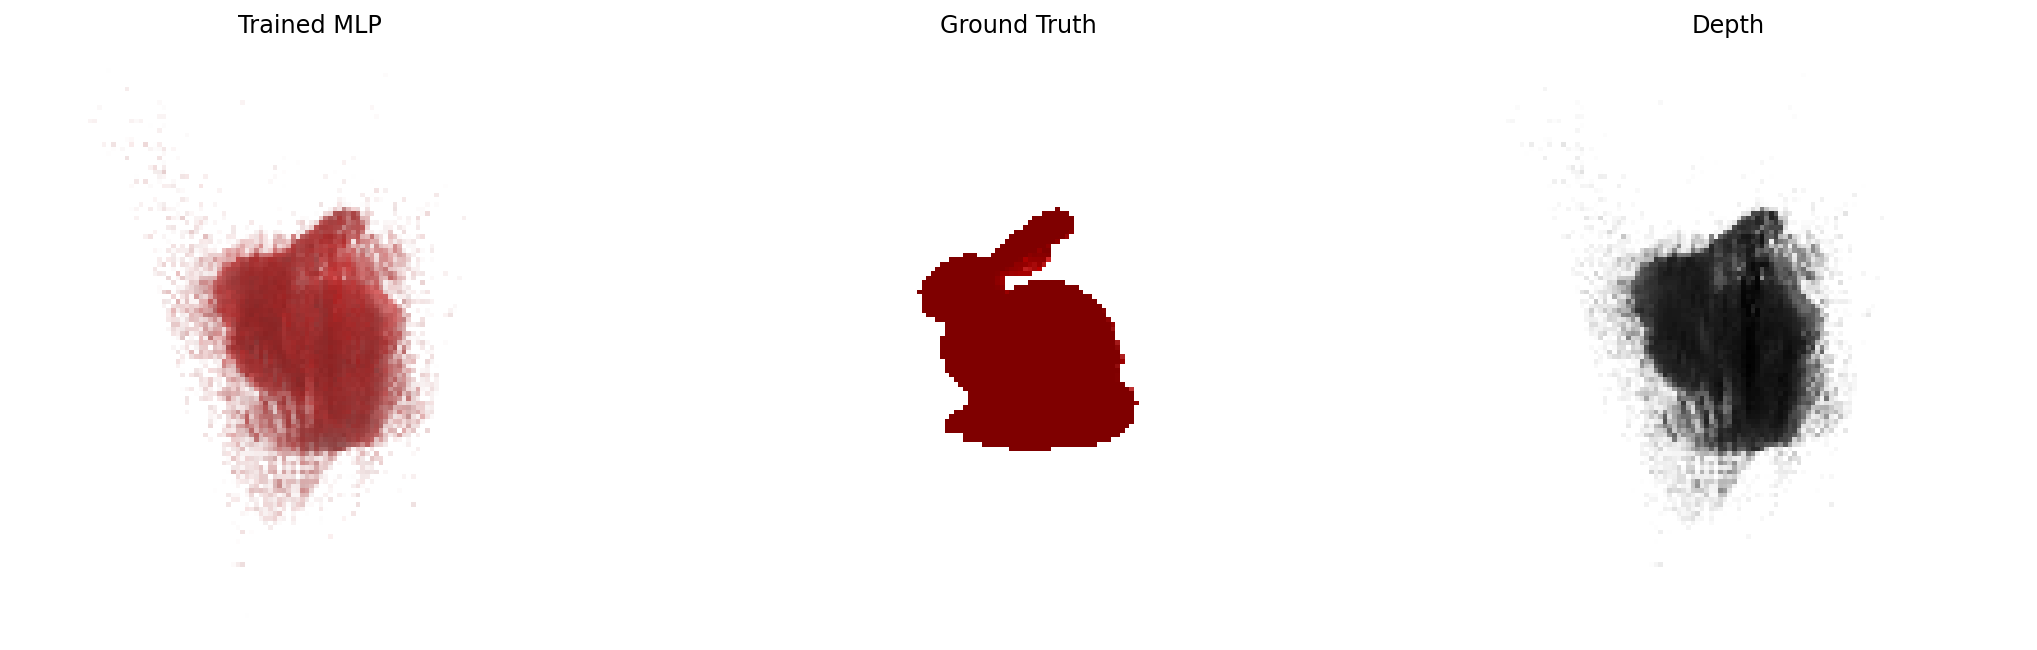

Step 2000: loss = 0.01


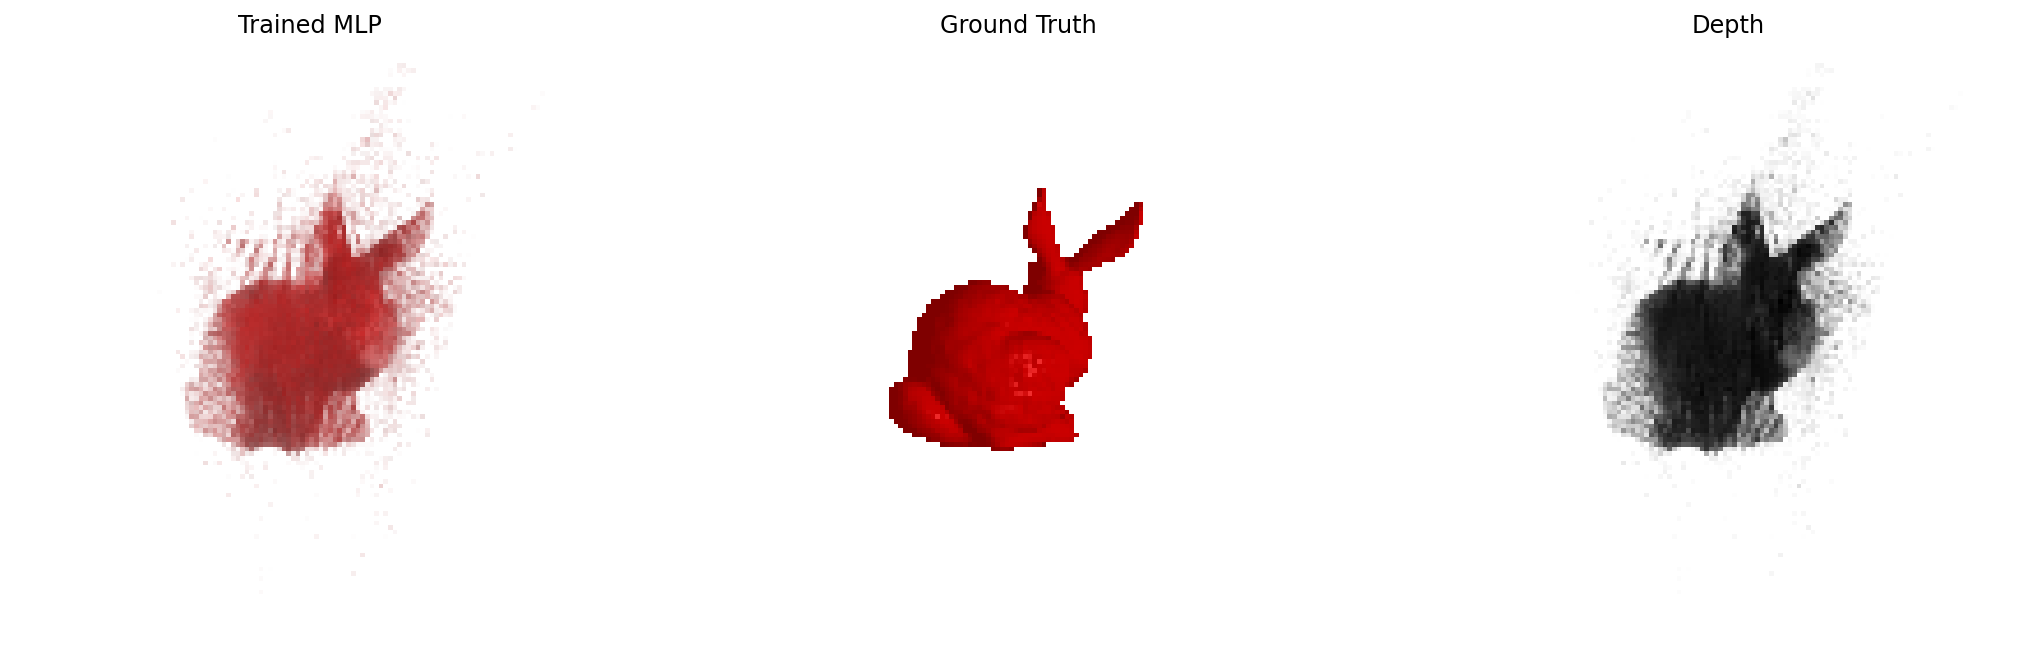

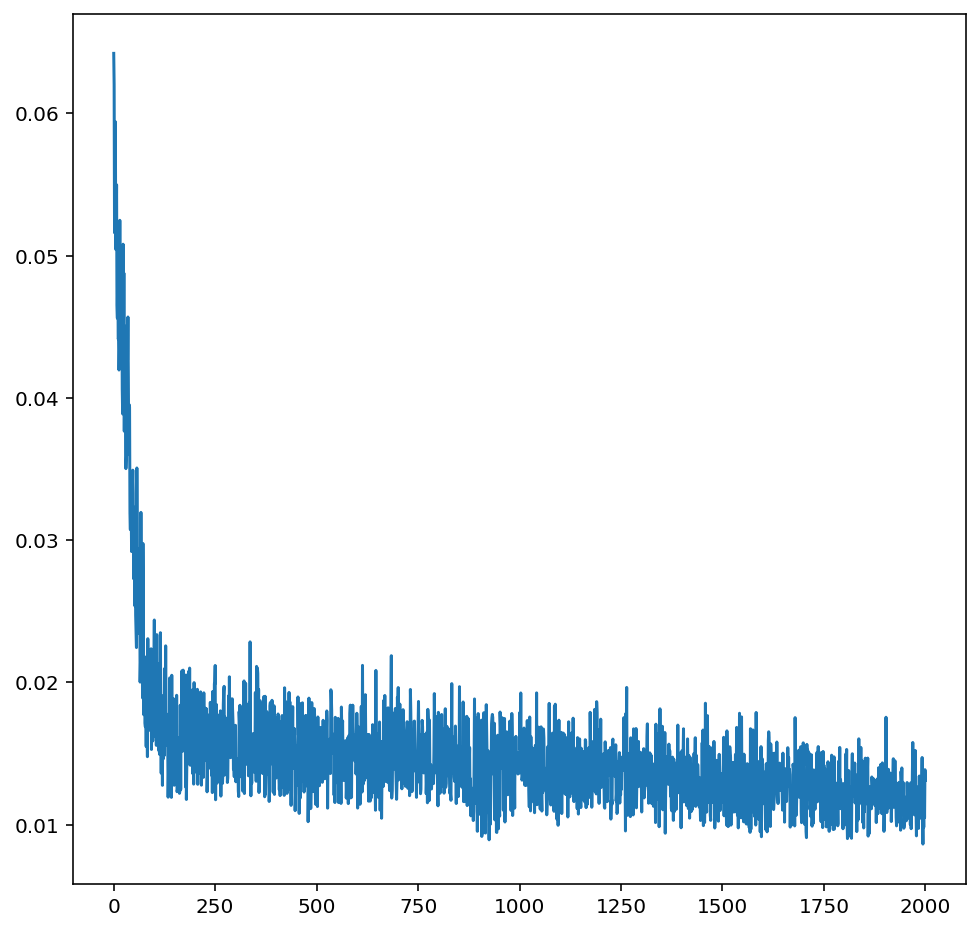

In [ ]:
# bunny_dataset = diff_rendering_dataset(images, cam2world) # added
# delete idx = 80 when generating bunny_dataset
fit_inverse_graphics_representation(rf, renderer, bunny_dataset, (128, 128, 3), lr=1e-3, total_steps=2_001)

In [ ]:
# %cd ..
!pwd
# %cd '/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library'
PATH_renderer = '/content/drive/MyDrive/Colab Notebooks/inverse graphics/hw2/renderer.pth'
PATH_rf = '/content/drive/MyDrive/Colab Notebooks/inverse graphics/hw2/rf.pth'
torch.save(renderer.state_dict(), PATH_renderer)
torch.save(rf.state_dict(), PATH_rf)

/content/drive/MyDrive/Colab Notebooks/inverse graphics/pytorch3d library


### 3.1.6. Rendering a video

To properly inspect our result, we'll render out a video.

In [ ]:
# rf = RadianceField().to(device) # was .cuda()
PATH_renderer = '/content/drive/MyDrive/Colab Notebooks/inverse graphics/hw2/renderer.pth'
PATH_rf = '/content/drive/MyDrive/Colab Notebooks/inverse graphics/hw2/rf.pth'
renderer = VolumeRenderer(near=1.5, far=4.5, n_samples=128, white_back=True, rand=False).to(device) # was .cuda()
renderer.load_state_dict(torch.load(PATH_renderer))
renderer.eval()

rf = RadianceField().to(device)
rf.load_state_dict(torch.load(PATH_rf))
rf.eval()


<All keys matched successfully>

In [ ]:
cam2world = np.load('cam2world.npy')
cam2world = torch.Tensor(cam2world).to(device)

images = torch.Tensor(images).to(device) # .cuda()
intrinsics = torch.tensor([[0.7, 0., 0.5],
                           [0., 0.7, 0.5],
                           [0., 0., 1.]]).to(device)

x_pix = get_opencv_pixel_coordinates(128, 128, device=device)
x_pix = x_pix.reshape(1, -1, 2)
with torch.no_grad():
    frames = []
    for i in range(len(cam2world)):
        model_in = {'cam2world': cam2world[i:i+1], 'intrinsics': intrinsics[None, ...], 'x_pix': x_pix}
        rgb, depth = renderer(model_in, rf)

        rgb = rgb.reshape(128, 128, 3).cpu().numpy()
        rgb *= 255
        rgb = np.clip(rgb, 0, 255).astype(np.uint8)
        frames.append(rgb)

In [ ]:
print(frames[0].shape)

f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

(128, 128, 3)


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)